# Polar night jet 

# Packages and handy functions

In [1]:
# Standard modules
import sys

# 3rd party modules
import xarray as xr
import numpy as np
from scipy import integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime


# we add our 'cesm_tools' directory to pythons look-up path
# then we can import python files using the 'import command'
sys.path.insert(0, "/home/slingbeek/scripts/cesm_tools/")
import cesm_scenarios2 # 'cesm_scenarios' contains the 'Scenario' class

# to suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def surf_mean(field):
    weights = np.cos(np.deg2rad(field.lat))
    weighted = field.weighted(weights)
    return weighted.mean(('lon','lat'))

In [3]:
def time_mean(field):
    ds = field
    ds['tw'] = (ds.time_bnds[:,1].astype("datetime64[ns]") - ds.time_bnds[:,0].astype("datetime64[ns]")).dt.days
    return ds.weighted(ds.tw).mean('time', keep_attrs=True).drop('tw')

In [4]:
def to_monthly(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month-0.5

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")

In [5]:
def jet_loc(ds, label, thresh, lats, plevs):
    def where_func(data):
        return xr.where(data >= thresh, True, False, keep_attrs=True)
    
    ds_cnt = ds.sel(lat=lats).sel(plev=plevs).map(where_func)
    return ds_cnt.rename({label:'count'})


In [6]:
def jet_max(data, label, lats, plev):
    dssel = data.sel(lat=lats).sel(plev=plev, method='nearest')

    ds_idxmax = dssel[label].idxmax(dim='lat')
    ds_maxval = dssel[label].max(dim='lat', keep_attrs=True)

    return xr.Dataset({'maxlat':ds_idxmax, 'maxval':ds_maxval, 'time_bnds':data.time_bnds}).assign_attrs(data.attrs)
    

In [7]:
p_ref = 100000
cp = 1004
Rdry = 286.9
kappa = Rdry/cp

def theta(ds):
    return ds.T*(p_ref/ds.plev)**kappa

def theta2(ds, var):
    return ds[var]*(p_ref/ds.plev)**kappa


In [8]:
Omega = 7.2921e-5
R = 286.9
a = 6.371e6

def Twind(t, u):
    t = t.isel(plev=slice(None, None, -1))
    
    slice_p = slice(850,5)
    
    f0 = 2*Omega*np.sin(np.deg2rad(t.lat))
    
    def uT_func(dset):
        return -(R/f0)*(dset.sel(plev=slice_p).T.differentiate(coord='lat'))/((np.pi/180)*a)*np.log(dset.plev.sel(plev=slice_p)/dset.plev.shift(plev=-1).sel(plev=slice_p))
        
    def vT_func(dset):
        return (R/f0)*(dset.sel(plev=slice_p).T.differentiate(coord='lon'))/((np.pi/180)*a*np.cos(np.deg2rad(dset.lat)))*np.log(dset.plev.sel(plev=slice_p)/dset.plev.shift(plev=-1).sel(plev=slice_p))
        
    uT = uT_func(t).cumsum(dim='plev')+u.U.sel(plev=850.)
    vT = vT_func(t).cumsum(dim='plev')
    
    return xr.Dataset({'uT':uT, 'vT':vT, 'time_bnds':t.time_bnds}).assign_attrs(t.attrs)
    


In [9]:
def EKE(u,v,uu,vv,t):
    ustar = uu['UU'] - u['U']*u['U']
    vstar = vv['VV'] - v['V']*v['V']
    eke = 0.5*(ustar + vstar)

    Rdry = 286.9
    rho = t.plev*100/(Rdry*t['T'])
    ekerho = 0.5*(ustar + vstar)*rho

    da1 = xr.DataArray(eke, dims=('time','lat','lon','plev'), coords=({'time':u.time, 'lat':u.lat, 'lon':u.lon, 'plev':u.plev})).assign_attrs(u.attrs)
    da2 = xr.DataArray(ekerho, dims=('time','lat','lon','plev'), coords=({'time':u.time, 'lat':u.lat, 'lon':u.lon, 'plev':u.plev})).assign_attrs(u.attrs)
    
    return xr.Dataset({'EKEm':da1, 'EKE':da2, 'time_bnds':u.time_bnds}).assign_attrs(u.attrs)


In [10]:
def KE(uu,vv,t):
    ke = uu['UU'] + vv['VV']

    Rdry = 286.9
    rho = t.plev*100/(Rdry*t['T'])

    kerho = (uu['UU'] + vv['VV'])*rho

    da1 = xr.DataArray(ke, dims=('time','lat','lon','plev'), coords=({'time':uu.time, 'lat':uu.lat, 'lon':uu.lon, 'plev':uu.plev})).assign_attrs(uu.attrs)
    da2 = xr.DataArray(kerho, dims=('time','lat','lon','plev'), coords=({'time':uu.time, 'lat':uu.lat, 'lon':uu.lon, 'plev':uu.plev})).assign_attrs(uu.attrs)

    return xr.Dataset({'KEm':da1, 'KE':da2, 'time_bnds':uu.time_bnds}).assign_attrs(uu.attrs)
    

In [11]:
save = True
imgsize1 = (7.5,2.5)
imgsize2 = (3.75,6)
imgsize3 = (7.5,5)

plt.rcParams.update({'font.size': 8})
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 300

slice_i = slice('2016','2035')
slice_f = slice('2111','2130')

scen = ['i_c', 'f_c', 'f_20', 'f_80']
diffscens = ['cref', '20ref', '80ref']

savepath = '/home/slingbeek/git_map/MScThesis/TeX/images/'


# Define scenarios and load data

In [12]:
# Meta data
dir = '/home/slingbeek/cesm2_data/monthly'
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': dir, 'years': np.arange(2015,2100)},
             'b.e21.BSSP585cmip6.f09_g17.control.06': {'directory': dir, 'years': np.arange(2100,2131)}
}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': dir,'years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': dir,'years': np.arange(2045,2100)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02': {'directory': dir,'years': np.arange(2100,2131)}
}
cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': dir, 'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': dir, 'years': np.arange(2086,2100)},
               'b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01': {'directory': dir, 'years': np.arange(2100,2131)}
}

cases = [cases_cnt, cases_sai20, cases_sai80]
scenario_names = ['Control', 'SAI 2020', 'SAI 2080']

# Define dictionary
scenarios = {name: cesm_scenarios2.Scenario(name,case) for name, case in zip(scenario_names,cases)}


In [13]:
# load data
scenarios['Control'].get_atm_var2('U')
scenarios['SAI 2020'].get_atm_var2('U')
scenarios['SAI 2080'].get_atm_var2('U')

scenarios['Control']['U']['plev'] = scenarios['Control']['U']['plev']/100
scenarios['SAI 2020']['U']['plev'] = scenarios['SAI 2020']['U']['plev']/100
scenarios['SAI 2080']['U']['plev'] = scenarios['SAI 2080']['U']['plev']/100


scenarios['Control'].get_atm_var2('V')
scenarios['SAI 2020'].get_atm_var2('V')
scenarios['SAI 2080'].get_atm_var2('V')

scenarios['Control']['V']['plev'] = scenarios['Control']['V']['plev']/100
scenarios['SAI 2020']['V']['plev'] = scenarios['SAI 2020']['V']['plev']/100
scenarios['SAI 2080']['V']['plev'] = scenarios['SAI 2080']['V']['plev']/100


scenarios['Control'].get_atm_var2('UU')
scenarios['SAI 2020'].get_atm_var2('UU')
scenarios['SAI 2080'].get_atm_var2('UU')

scenarios['Control']['UU']['plev'] = scenarios['Control']['UU']['plev']/100
scenarios['SAI 2020']['UU']['plev'] = scenarios['SAI 2020']['UU']['plev']/100
scenarios['SAI 2080']['UU']['plev'] = scenarios['SAI 2080']['UU']['plev']/100


scenarios['Control'].get_atm_var2('VV')
scenarios['SAI 2020'].get_atm_var2('VV')
scenarios['SAI 2080'].get_atm_var2('VV')

scenarios['Control']['VV']['plev'] = scenarios['Control']['VV']['plev']/100
scenarios['SAI 2020']['VV']['plev'] = scenarios['SAI 2020']['VV']['plev']/100
scenarios['SAI 2080']['VV']['plev'] = scenarios['SAI 2080']['VV']['plev']/100


scenarios['Control'].get_atm_var2('T')
scenarios['SAI 2020'].get_atm_var2('T')
scenarios['SAI 2080'].get_atm_var2('T')

scenarios['Control']['T']['theta'] = theta(scenarios['Control']['T'])
scenarios['SAI 2020']['T']['theta'] = theta(scenarios['SAI 2020']['T'])
scenarios['SAI 2080']['T']['theta'] = theta(scenarios['SAI 2080']['T'])

scenarios['Control']['T']['plev'] = scenarios['Control']['T']['plev']/100
scenarios['SAI 2020']['T']['plev'] = scenarios['SAI 2020']['T']['plev']/100
scenarios['SAI 2080']['T']['plev'] = scenarios['SAI 2080']['T']['plev']/100


In [14]:
latmin = -90.0
latmax = -0.

### select data at right time and high lat
U = {
    'f_c':scenarios['Control']['U'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['U'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['U'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['U'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['U'].sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

UU = {
    'f_c':scenarios['Control']['UU'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['UU'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['UU'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['UU'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['UU'].sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

V = {
    'f_c':scenarios['Control']['V'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['V'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['V'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['V'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['V'].sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

VV = {
    'f_c':scenarios['Control']['VV'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['VV'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['VV'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['VV'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['VV'].sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

T = {
    'f_c':scenarios['Control']['T'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['T'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['T'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['T'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['T'].sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

# Jet location and maximum

In [15]:
latmin = -85
latmax = -30
plevmin = 1
plevmax = 50

PNJ = {}
for i in scen:
    PNJ[i] = jet_loc(U[i].sel(time=U[i].time.dt.month.isin([8,9,10])), 'U', 80, lats=slice(latmin,latmax), plevs=slice(plevmin,plevmax))['count']


In [16]:
latmin = -85
latmax = -30
plevmax = 10

PNJmax = {}
for i in scen:
    PNJmax[i] = time_mean(jet_max(U[i].sel(time=U[i].time.dt.month.isin([8,9,10])), 'U', lats=slice(latmin,latmax), plev=plevmax))


In [17]:
PNJpm = {}
for i in scen:
    PNJpm[i] = (PNJ[i].sum(dim=['time','plev'])/(len(PNJ[i].time)*len(PNJ[i].plev))).compute()


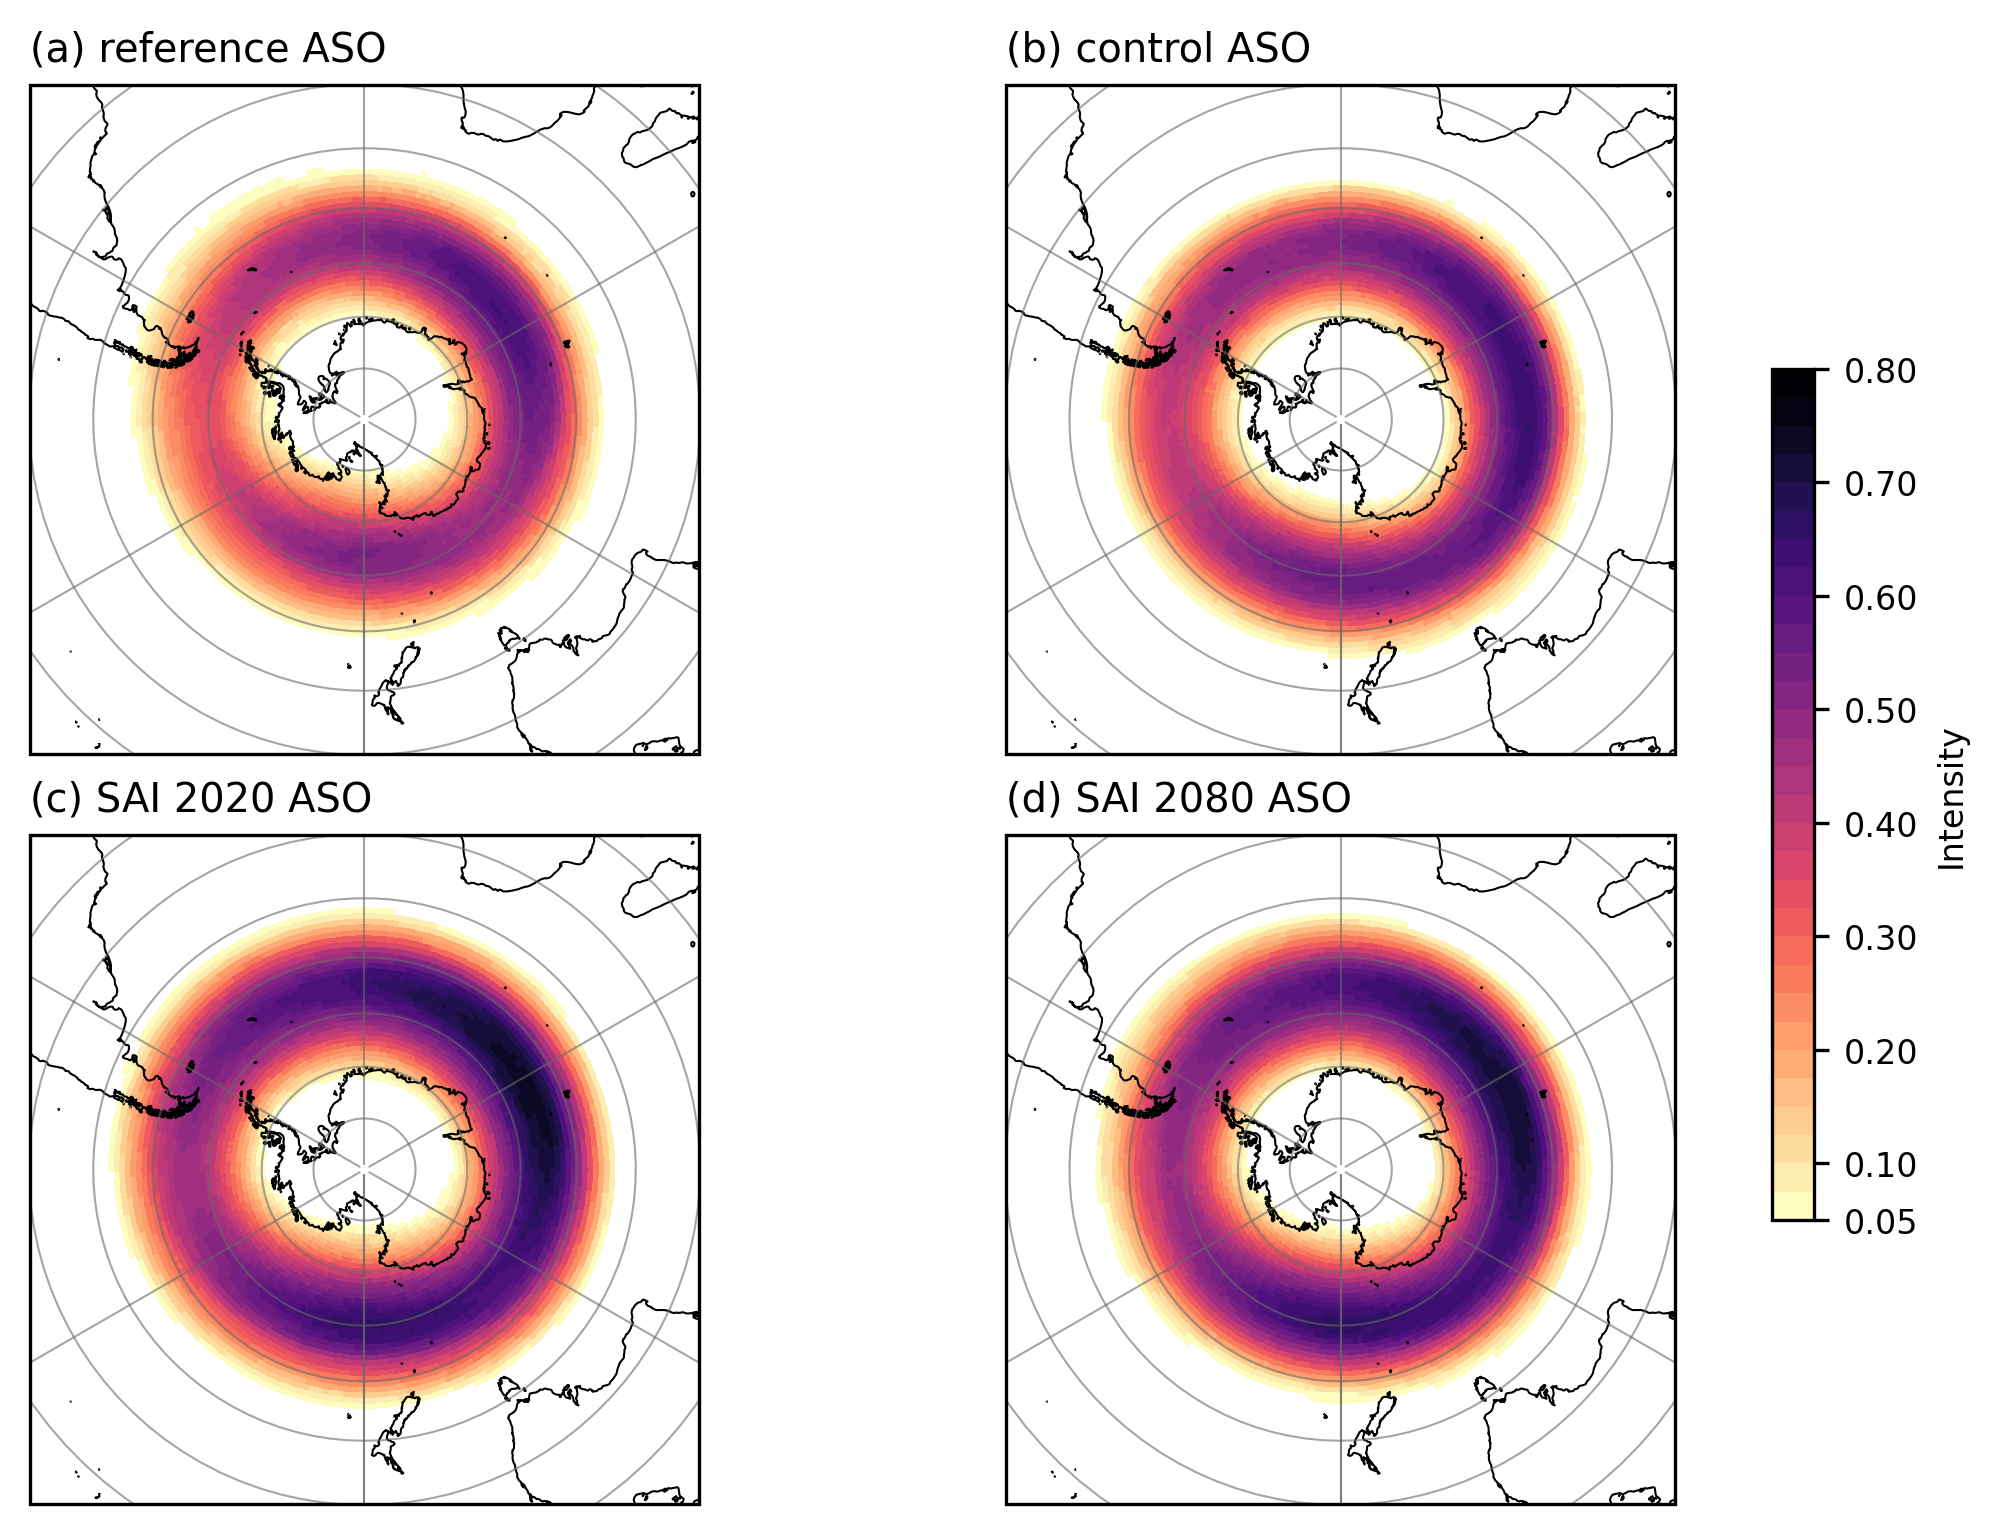

In [18]:
labels = ['(a) reference ASO', '(b) control ASO', '(c) SAI 2020 ASO', '(d) SAI 2080 ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained', subplot_kw={'projection':ccrs.SouthPolarStereo(central_longitude=0, globe=None)})

ax = axs.flatten()
for i in range(len(scen)):
    ax[i].coastlines(resolution='50m', linewidth=0.5)
    
    plot = PNJpm[scen[i]].plot(ax=ax[i], transform=ccrs.PlateCarree(), cmap=plt.get_cmap('magma_r',30), extend='neither', vmin=0.05, vmax=0.8, add_colorbar=False) 
    plot.cmap.set_under('w')
    ax[i].set_title(labels[i], loc='left', fontsize='large')

    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')

plt.colorbar(plot, ax=axs, shrink=0.6, location='right', label=r'Intensity', extend='neither', ticks=[0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])


if save == True: plt.savefig(savepath+'PNJ_map.png');


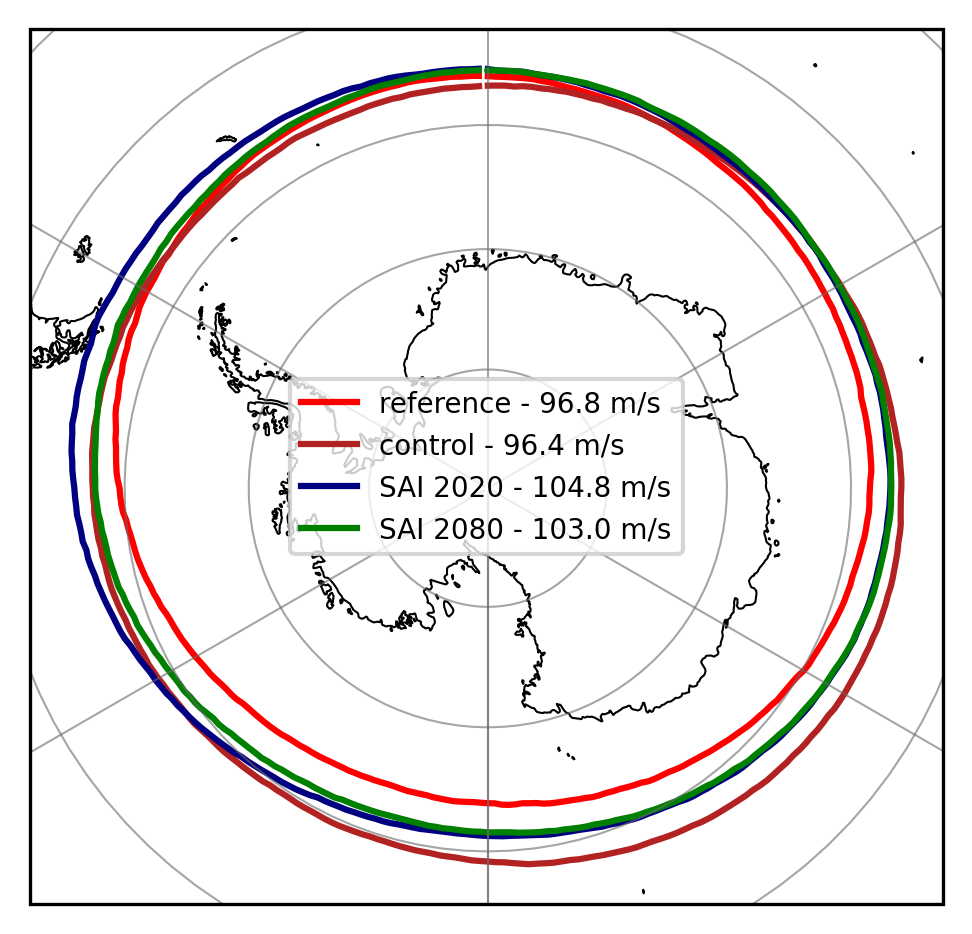

In [19]:
scen = ['i_c', 'f_c', 'f_20', 'f_80']
labels = ['reference', 'control', 'SAI 2020', 'SAI 2080']
cols = ['red', 'firebrick', 'navy', 'green']

fig = plt.figure(figsize=(4,3), layout='constrained')

ax1 = fig.add_subplot(1,1,1,projection=ccrs.SouthPolarStereo(central_longitude=0, globe=None))
ax1.coastlines(resolution='50m', linewidth=0.5)

for i in range(len(scen)):
    PNJmax[scen[i]]['maxlat'].plot(ax=ax1, transform=ccrs.PlateCarree(), color=cols[i], label=labels[i] + ' - ' + str(np.round(PNJmax[scen[i]]['maxval'].mean(dim='lon').values, decimals=1))+' m/s')

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='dimgray', alpha=0.6, linestyle='-')

ax1.legend(fontsize='small')
# ax1.set_title('Polar Night Jet maximum location at 10 hPa')
ax1.set_title('')

if save == True: plt.savefig(savepath+'PNJ_maxloc_latlon.png');


# Climograph

In [20]:
latmin = -90
latmax = -60

slice_f2 = slice('2101','2130')
slice_i2 = slice('2016', '2045')

Tc = {
    'f_c':scenarios['Control']['T'].sel(time=slice_f2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['T'].sel(time=slice_i2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['T'].sel(time=slice_f2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['T'].sel(time=slice_i2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['T'].sel(time=slice_f2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax))
}

U2 = {
    'f_c':scenarios['Control']['U'].sel(time=slice_f2).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['U'].sel(time=slice_i2).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['U'].sel(time=slice_f2).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['U'].sel(time=slice_i2).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['U'].sel(time=slice_f2).sel(lat=slice(latmin,latmax))
}

In [21]:
TPNJ = {}
UPNJ = {}
for i in scen:
    TPNJ[i] = to_monthly(surf_mean(Tc[i]['T']))
    UPNJ[i] = to_monthly(U2[i].sel(plev=10, method='nearest').sel(lat=latmax, method='nearest')['U'].mean(dim='lon'))


In [22]:
TPNJ['i_c']

<xarray.DataArray 'T' (year: 30, month: 12)> Size: 3kB
dask.array<reshape, shape=(30, 12), dtype=float64, chunksize=(1, 12), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 240B 2016 2017 2018 2019 2020 ... 2042 2043 2044 2045
  * month    (month) float64 96B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
    plev     float64 8B 10.0

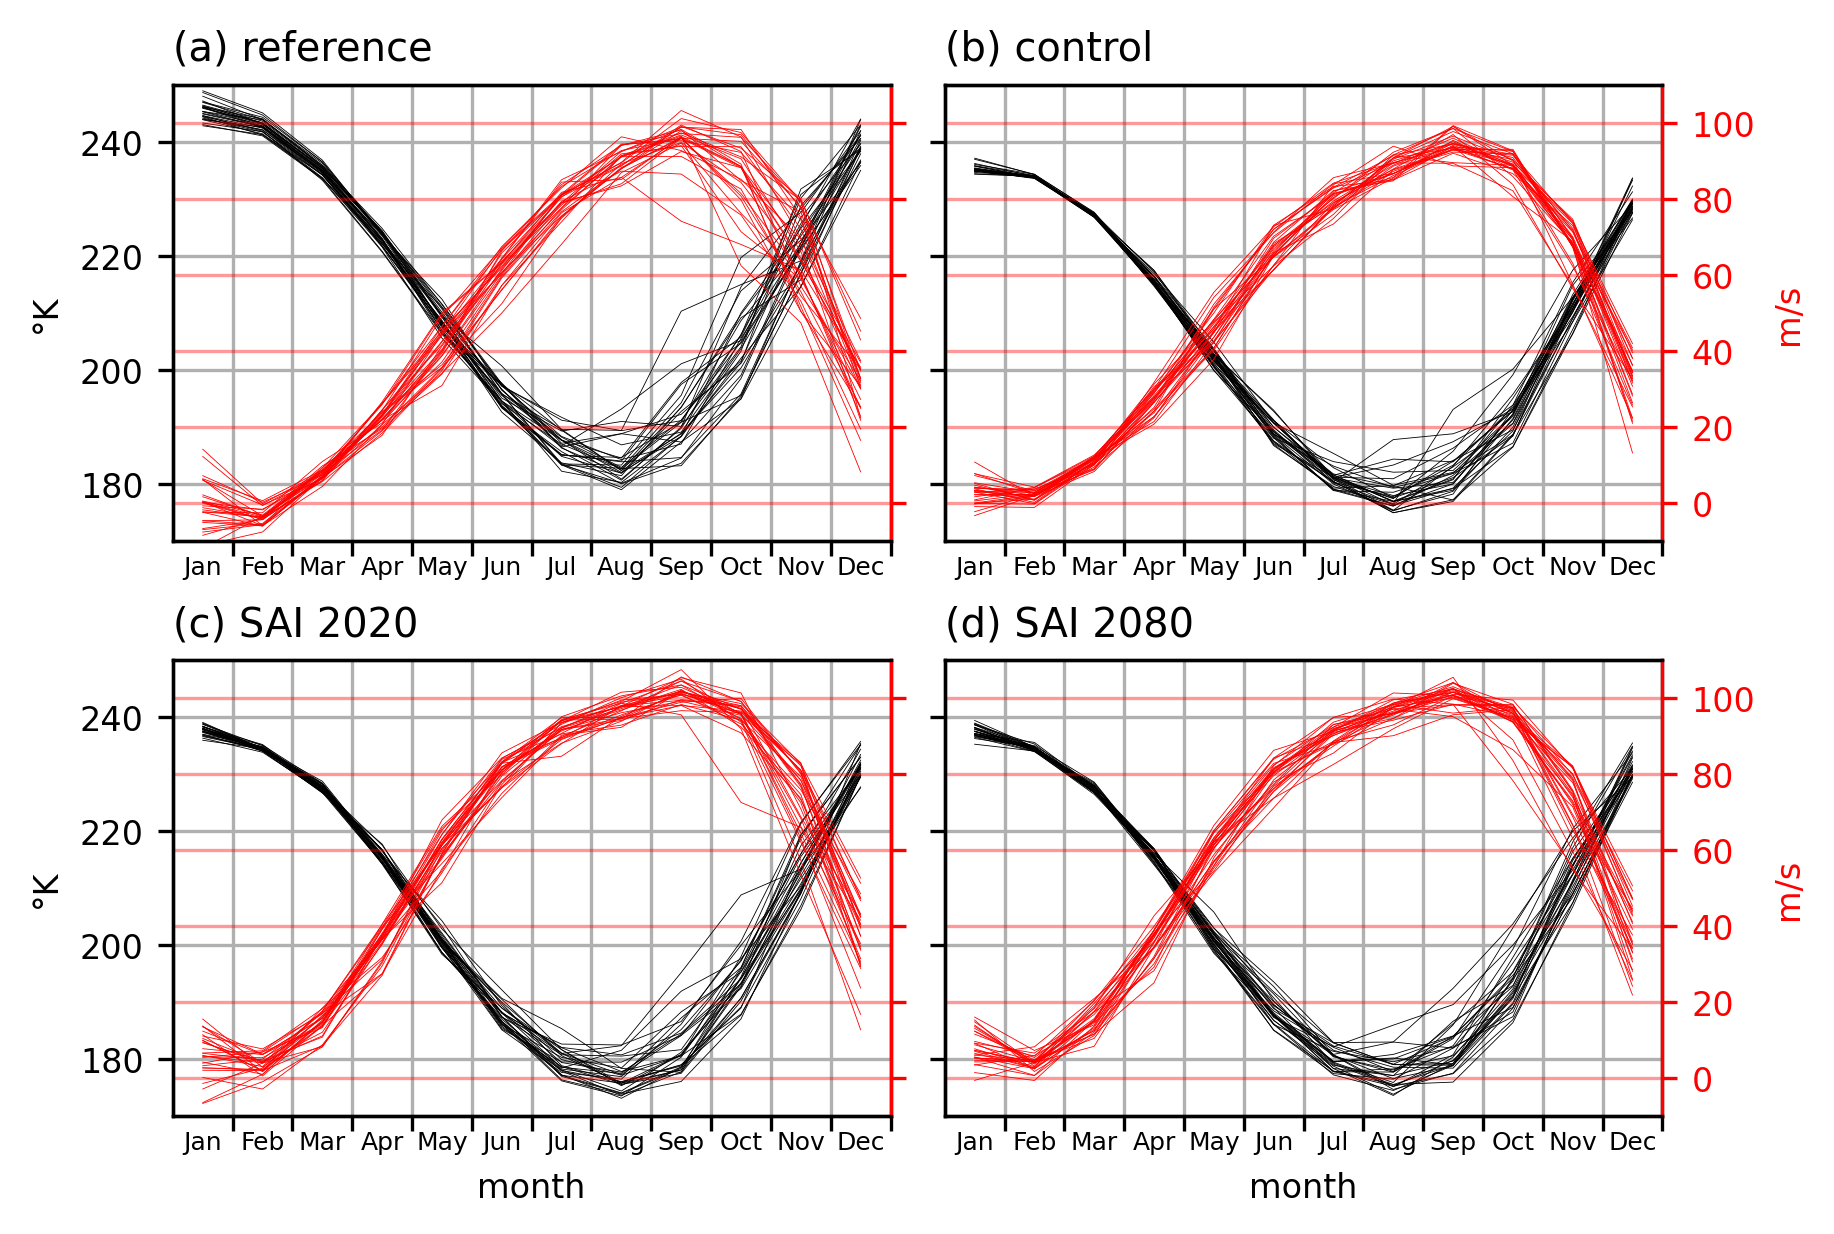

In [23]:
labels = ['(a) reference', '(b) control', '(c) SAI 2020', '(d) SAI 2080']

fig, axs = plt.subplots(2, 2, figsize=(6,4), layout='constrained')

ax = axs.flatten()
for i in range(len(scen)):
    ax1 = ax[i]
    
    plot1 = TPNJ[scen[i]].plot(x='month', hue='year', ax=ax1, linewidth=0.2, color='k', add_legend=False) 
    ax1.set_xlim(0,12)
    ax1.set_xticks(np.arange(1,13,1))

    ax1.xaxis.set_major_formatter(mticker.NullFormatter())
    ax1.xaxis.set_minor_locator(mticker.FixedLocator(np.arange(0.5,12.5,1)))

    ax1.tick_params(axis='x', which='minor', length=0.)
    ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], minor=True, size=6)
    
    ax1.set_ylim(170,250)
    ax1.grid()
    ax1.set_xlabel(None)
    ax1.set_ylabel(None)

    ax2 = ax1.twinx()
  
    UPNJ[scen[i]].plot(x='month', hue='year', ax=ax2, linewidth=0.2, color='red', add_legend=False)
    ax2.set_ylim(-10,110)
    ax2.grid(color='red', alpha=0.4)
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)

    ax1.set_title(None)
    ax2.set_title(None)
    ax1.set_title(labels[i], loc='left', fontsize='large')
    
    if ax[i] == ax[0] or ax[i] == ax[2]:
        ax2.tick_params(axis='y', colors='red')
        ax2.set_yticklabels([])

    else:
        ax1.set_yticklabels([])     
        ax2.set_ylabel('m/s', color='red')
        ax2.tick_params(axis='y', colors='red')
    
    ax2.spines['right'].set_color('red')


ax[2].set_xlabel('month')
ax[3].set_xlabel('month')
ax[0].set_ylabel('°K')
ax[2].set_ylabel('°K')

if save == True: plt.savefig(savepath+'PNJ_climographTU.png');

In [24]:
latmin = -60
latmax = -30

slice_f2 = slice('2101','2130')
slice_i2 = slice('2016', '2045')

T_60 = {
    'f_c':scenarios['Control']['T'].sel(time=slice_f2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['T'].sel(time=slice_i2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['T'].sel(time=slice_f2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['T'].sel(time=slice_i2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['T'].sel(time=slice_f2).sel(plev=10, method='nearest').sel(lat=slice(latmin,latmax))
}

# U2_60 = {
#     'f_c':scenarios['Control']['U'].sel(time=slice_f2).sel(lat=slice(latmin,latmax)),
#     'i_c':scenarios['Control']['U'].sel(time=slice_i2).sel(lat=slice(latmin,latmax)),

#     'f_20':scenarios['SAI 2020']['U'].sel(time=slice_f2).sel(lat=slice(latmin,latmax)),
#     'i_20':scenarios['SAI 2020']['U'].sel(time=slice_i2).sel(lat=slice(latmin,latmax)),

#     'f_80':scenarios['SAI 2080']['U'].sel(time=slice_f2).sel(lat=slice(latmin,latmax))
# }

In [25]:
TPNJ60 = {}
TPNJdiff = {}
# UPNJ60 = {}
for i in scen:
    TPNJ60[i] = to_monthly(surf_mean(T_60[i]['T']))
    TPNJdiff[i] = to_monthly(surf_mean(T_60[i]['T']))-TPNJ[i]

    # UPNJ60[i] = to_monthly(U2_60[i].sel(plev=10, method='nearest').sel(lat=latmax, method='nearest')['U'].mean(dim='lon'))


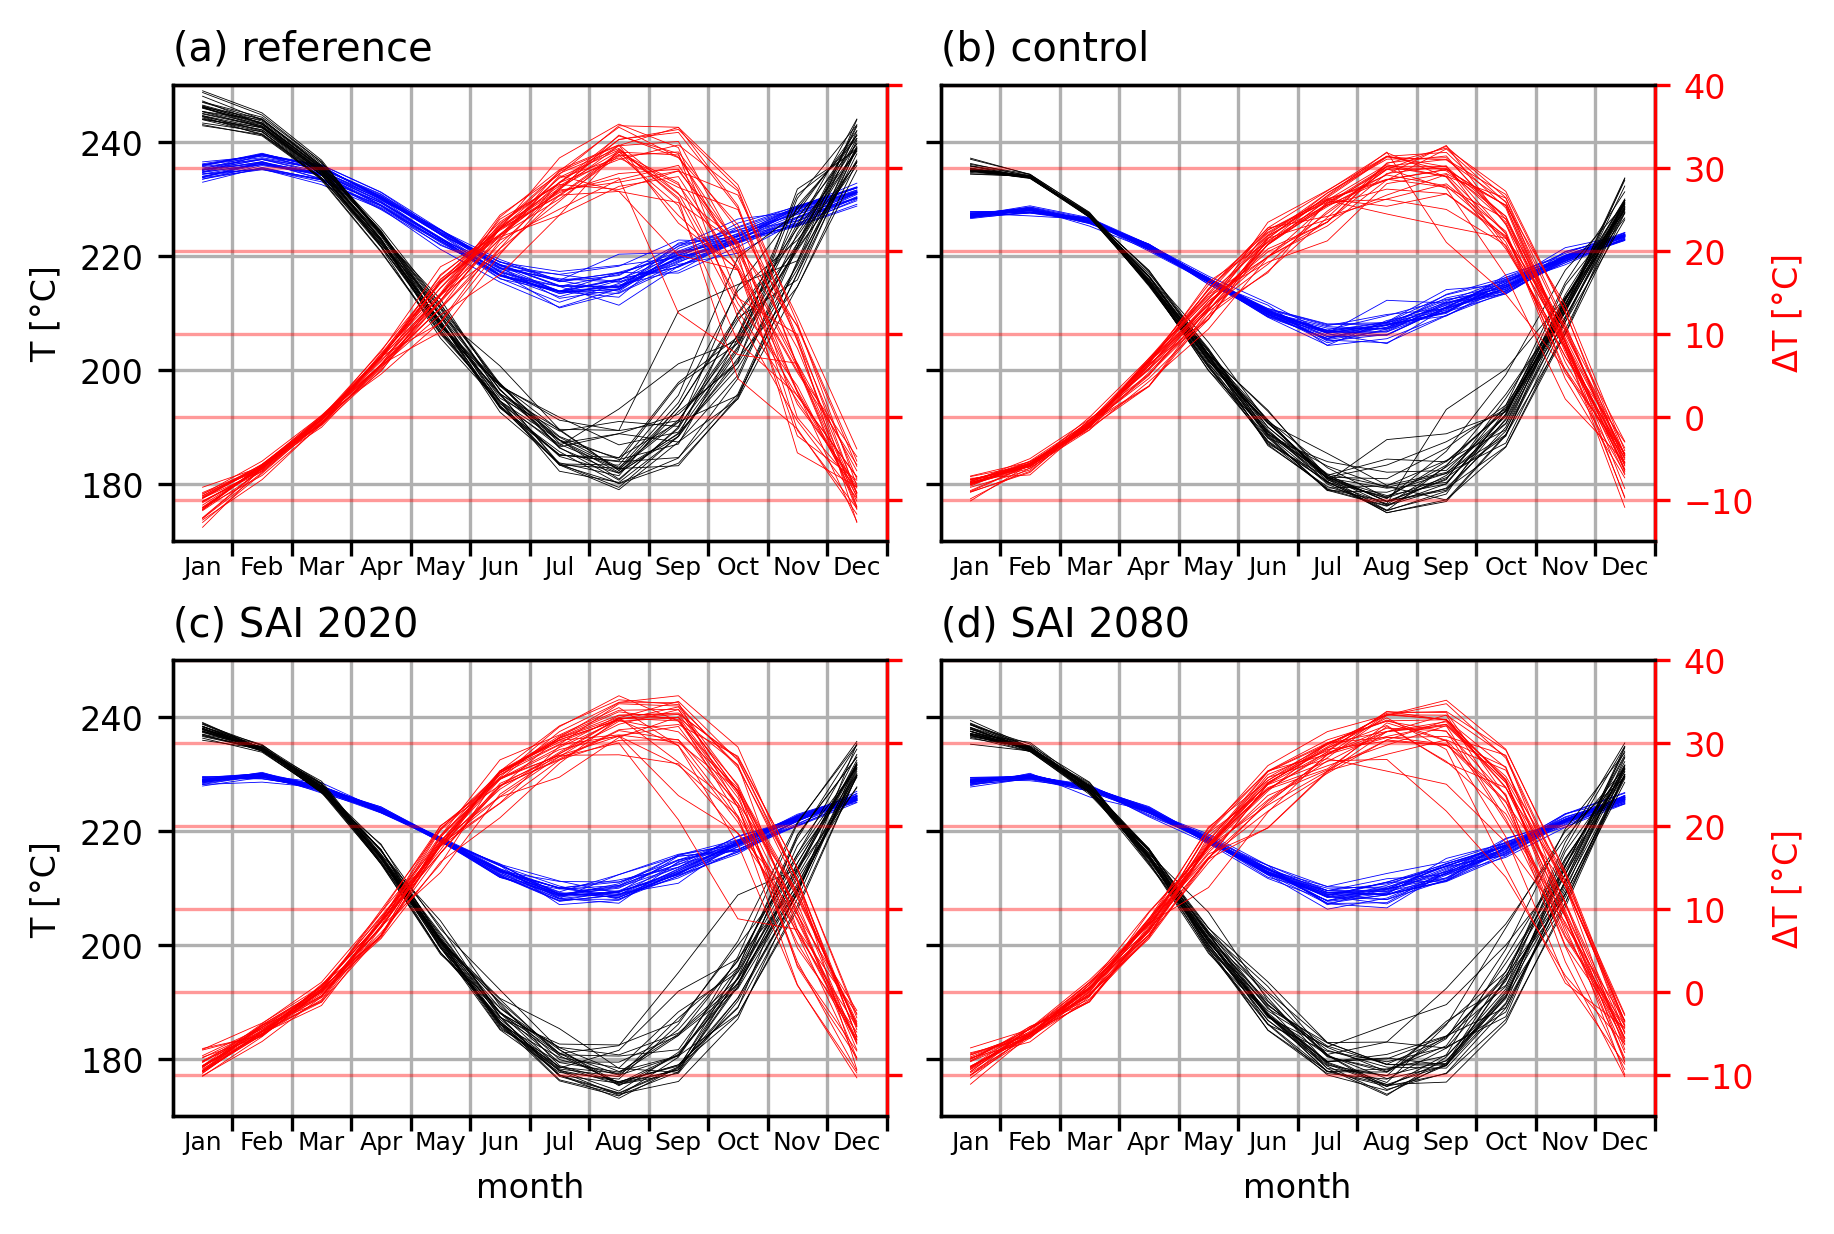

In [26]:
labels = ['(a) reference', '(b) control', '(c) SAI 2020', '(d) SAI 2080']

fig, axs = plt.subplots(2, 2, figsize=(6,4), layout='constrained')

ax = axs.flatten()
for i in range(len(scen)):
    ax1 = ax[i]
    
    plot1 = TPNJ60[scen[i]].plot(x='month', hue='year', ax=ax1, linewidth=0.2, color='b', add_legend=False) 
    plot1 = TPNJ[scen[i]].plot(x='month', hue='year', ax=ax1, linewidth=0.2, color='k', add_legend=False) 

    ax1.set_xlim(0,12)
    ax1.set_xticks(np.arange(1,13,1))

    ax1.xaxis.set_major_formatter(mticker.NullFormatter())
    ax1.xaxis.set_minor_locator(mticker.FixedLocator(np.arange(0.5,12.5,1)))

    ax1.tick_params(axis='x', which='minor', length=0.)
    ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], minor=True, size=6)
    
    ax1.set_ylim(170,250)
    ax1.grid()
    ax1.set_xlabel(None)
    ax1.set_ylabel(None)

    ax2 = ax1.twinx()
  
    TPNJdiff[scen[i]].plot(x='month', hue='year', ax=ax2, linewidth=0.2, color='red', add_legend=False)
    ax2.set_ylim(-15,40)
    ax2.grid(color='red', alpha=0.4)
    ax2.set_xlabel(None)
    ax2.set_ylabel(None)

    ax1.set_title(None)
    ax2.set_title(None)
    ax1.set_title(labels[i], loc='left', fontsize='large')
    
    if ax[i] == ax[0] or ax[i] == ax[2]:
        ax2.tick_params(axis='y', colors='red')
        ax2.set_yticklabels([])

    else:
        ax1.set_yticklabels([])     
        ax2.set_ylabel(r'$\Delta$T [°C]', color='red')
        ax2.tick_params(axis='y', colors='red')
    
    ax2.spines['right'].set_color('red')


ax[2].set_xlabel('month')
ax[3].set_xlabel('month')
ax[0].set_ylabel('T [°C]')
ax[2].set_ylabel('T [°C]')

if save == True: plt.savefig(savepath+'climographTdT.png');

# Kinetic energy/eddy kinetic energy

In [27]:
### calculate zonal mean eddy kinetic energy 
EKEmzm = {}
KEmzm = {}
Uzm = {}

for i in scen:
    EKEmzm[i] = time_mean(EKE(U[i].sel(time=U[i].time.dt.month.isin([8,9,10])),V[i].sel(time=V[i].time.dt.month.isin([8,9,10])),
                              UU[i].sel(time=UU[i].time.dt.month.isin([8,9,10])),VV[i].sel(time=VV[i].time.dt.month.isin([8,9,10])),
                              T[i].sel(time=T[i].time.dt.month.isin([8,9,10]))))['EKEm'].mean(dim='lon')
    
    KEmzm[i] = time_mean(KE(UU[i].sel(time=UU[i].time.dt.month.isin([8,9,10])),VV[i].sel(time=VV[i].time.dt.month.isin([8,9,10])),
                           T[i].sel(time=T[i].time.dt.month.isin([8,9,10]))))['KEm'].mean(dim='lon')

    Uzm[i] = time_mean(U[i].sel(time=U[i].time.dt.month.isin([8,9,10])))['U'].mean(dim='lon')


In [28]:
for i in scen:
    EKEmzm[i].compute()
    KEmzm[i].compute()
    Uzm[i].compute()


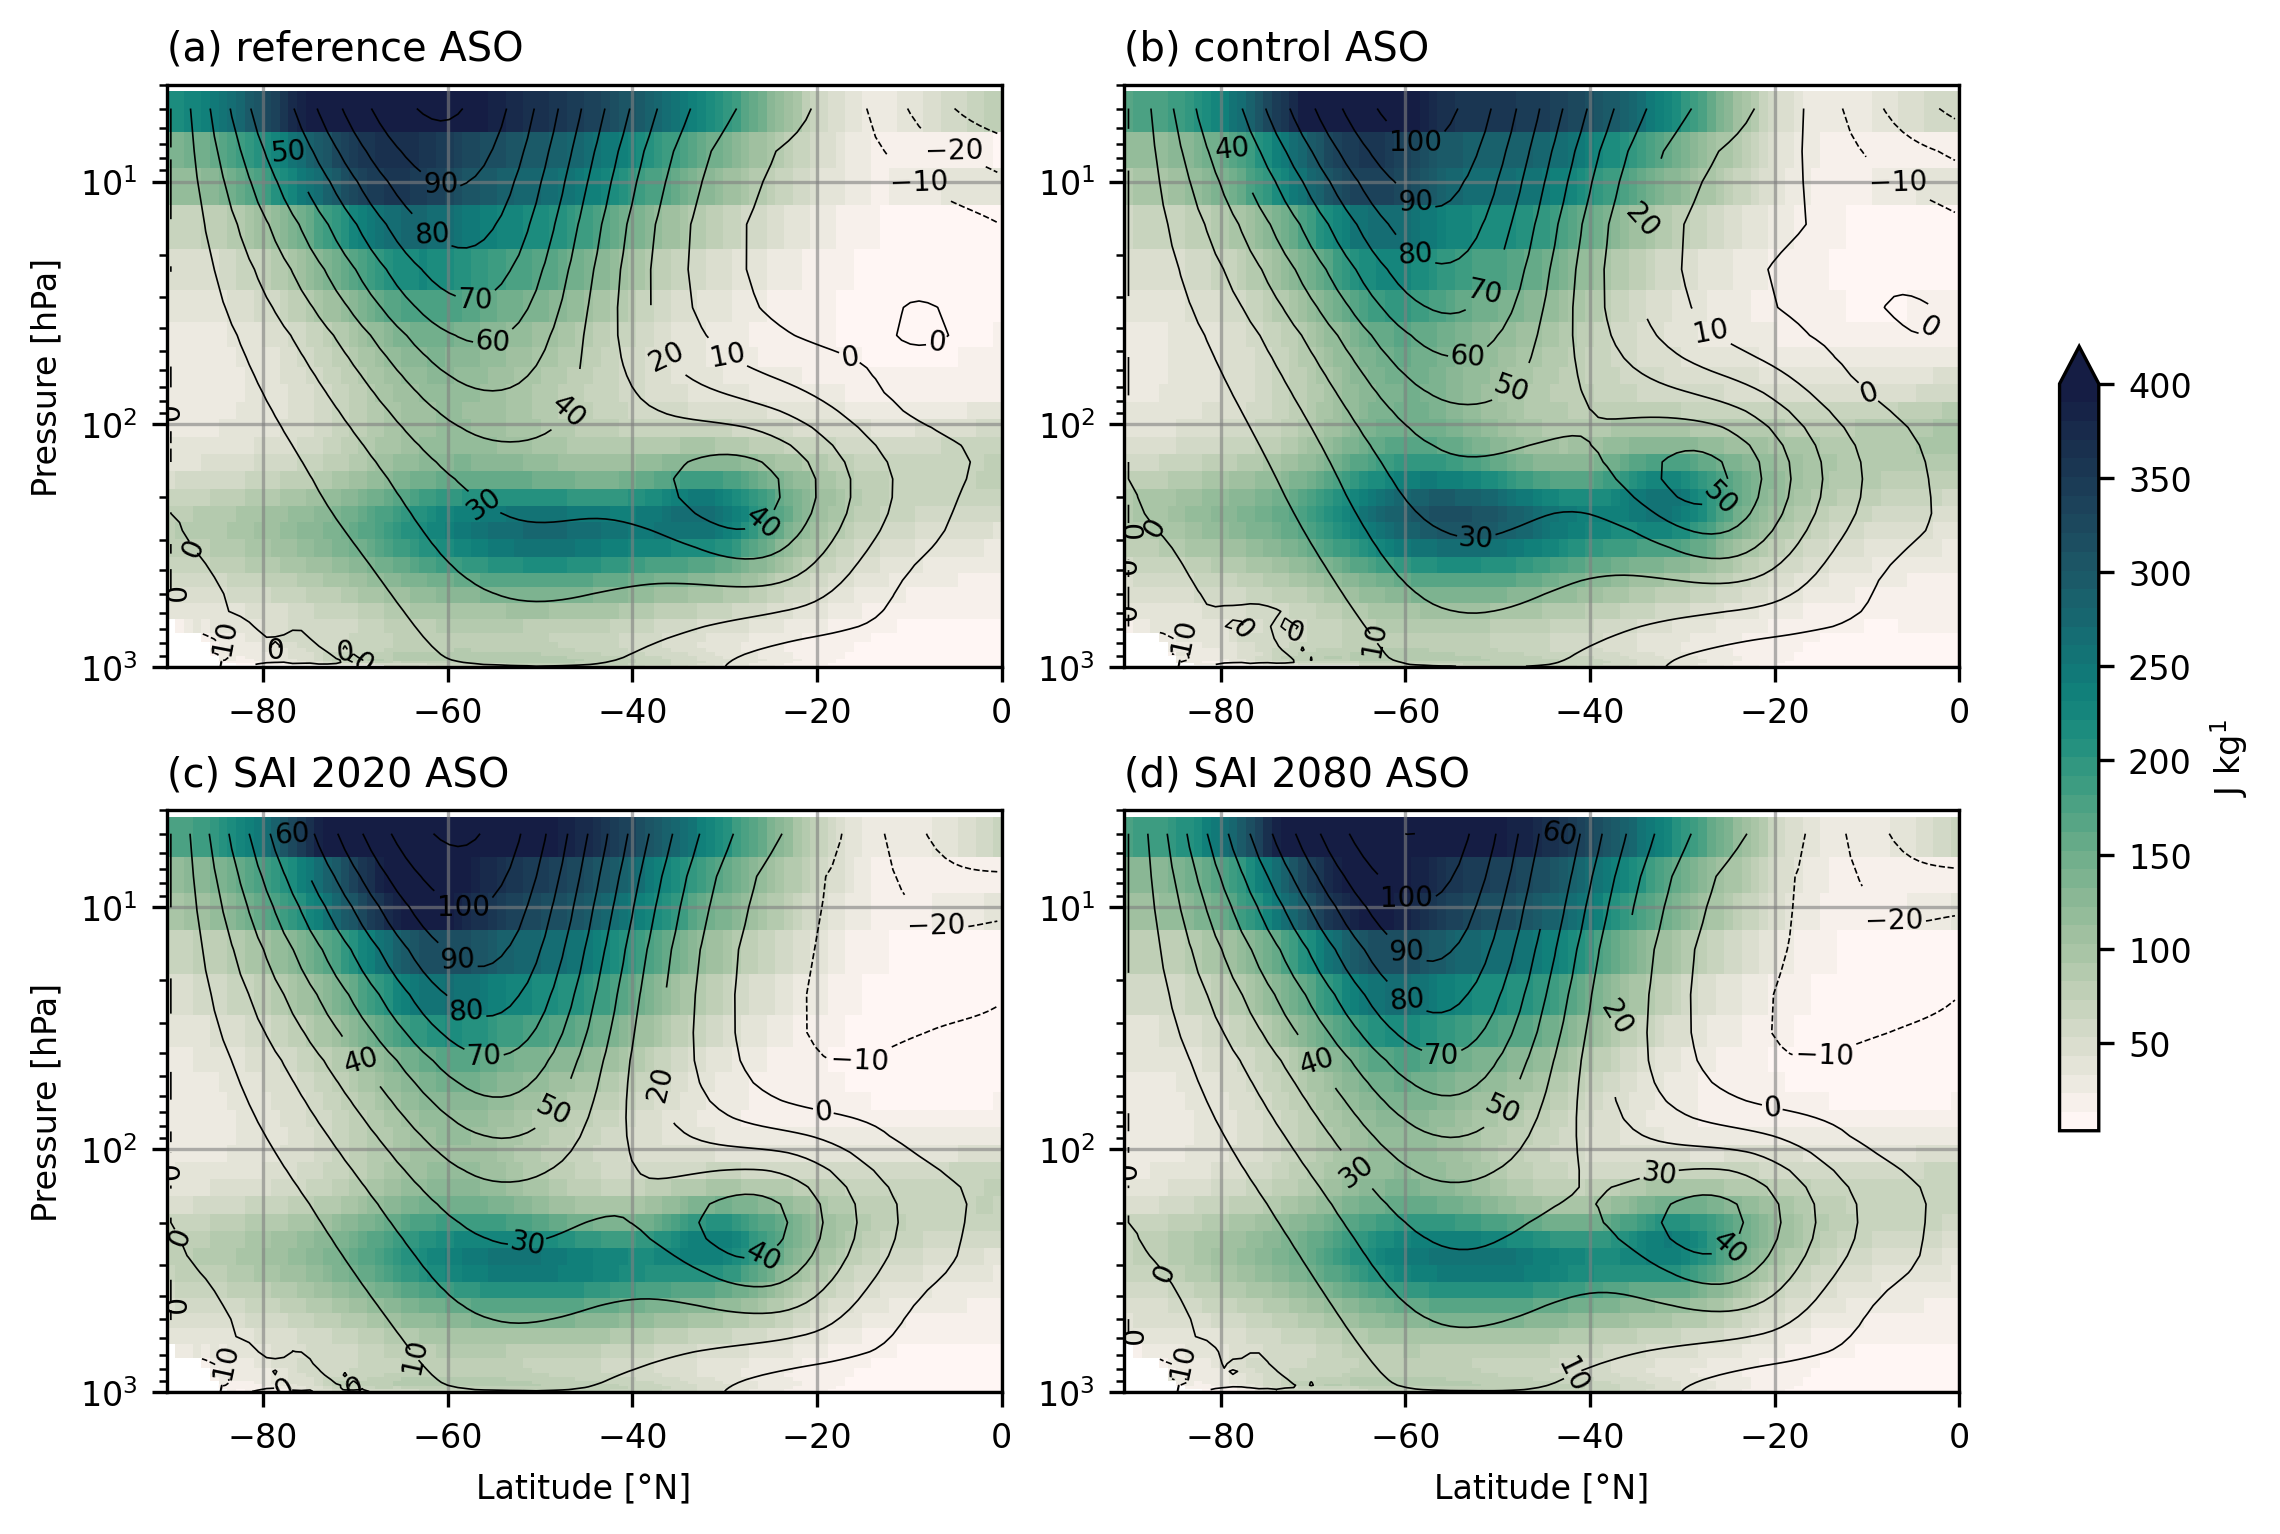

In [29]:
scen_used = ['i_c', 'f_c', 'f_20', 'f_80']
labels = ['(a) reference ASO', '(b) control ASO', '(c) SAI 2020 ASO', '(d) SAI 2080 ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained')

for i,j,k in zip(axs.flatten(),scen_used,labels):
    im = EKEmzm[j].plot(ax=i, x='lat', y='plev', cmap=plt.get_cmap('cmo.tempo',40), vmax=400, add_colorbar=False)

    plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-120, vmax=120, levels=25, kwargs=dict(inline=True))
    i.clabel(plot, fontsize='small', inline_spacing=1)

    i.set_xlabel(None)
    i.set_ylabel(None)
    i.invert_yaxis()
    i.set_yscale('log')
    i.grid(color='gray', alpha=0.6)
    i.set_ylim(10**3,4)

    i.set_title(k, loc='left')

axs[1,0].set_xlabel('Latitude [°N]')
axs[1,1].set_xlabel('Latitude [°N]')
axs[0,0].set_ylabel('Pressure [hPa]')
axs[1,0].set_ylabel('Pressure [hPa]')


plt.colorbar(im, ax=axs, shrink=0.6, location='right', label=r'J kg$^1$', extend='max')

if save == True: plt.savefig(savepath+'PNJ_EKE_U_zm.png');


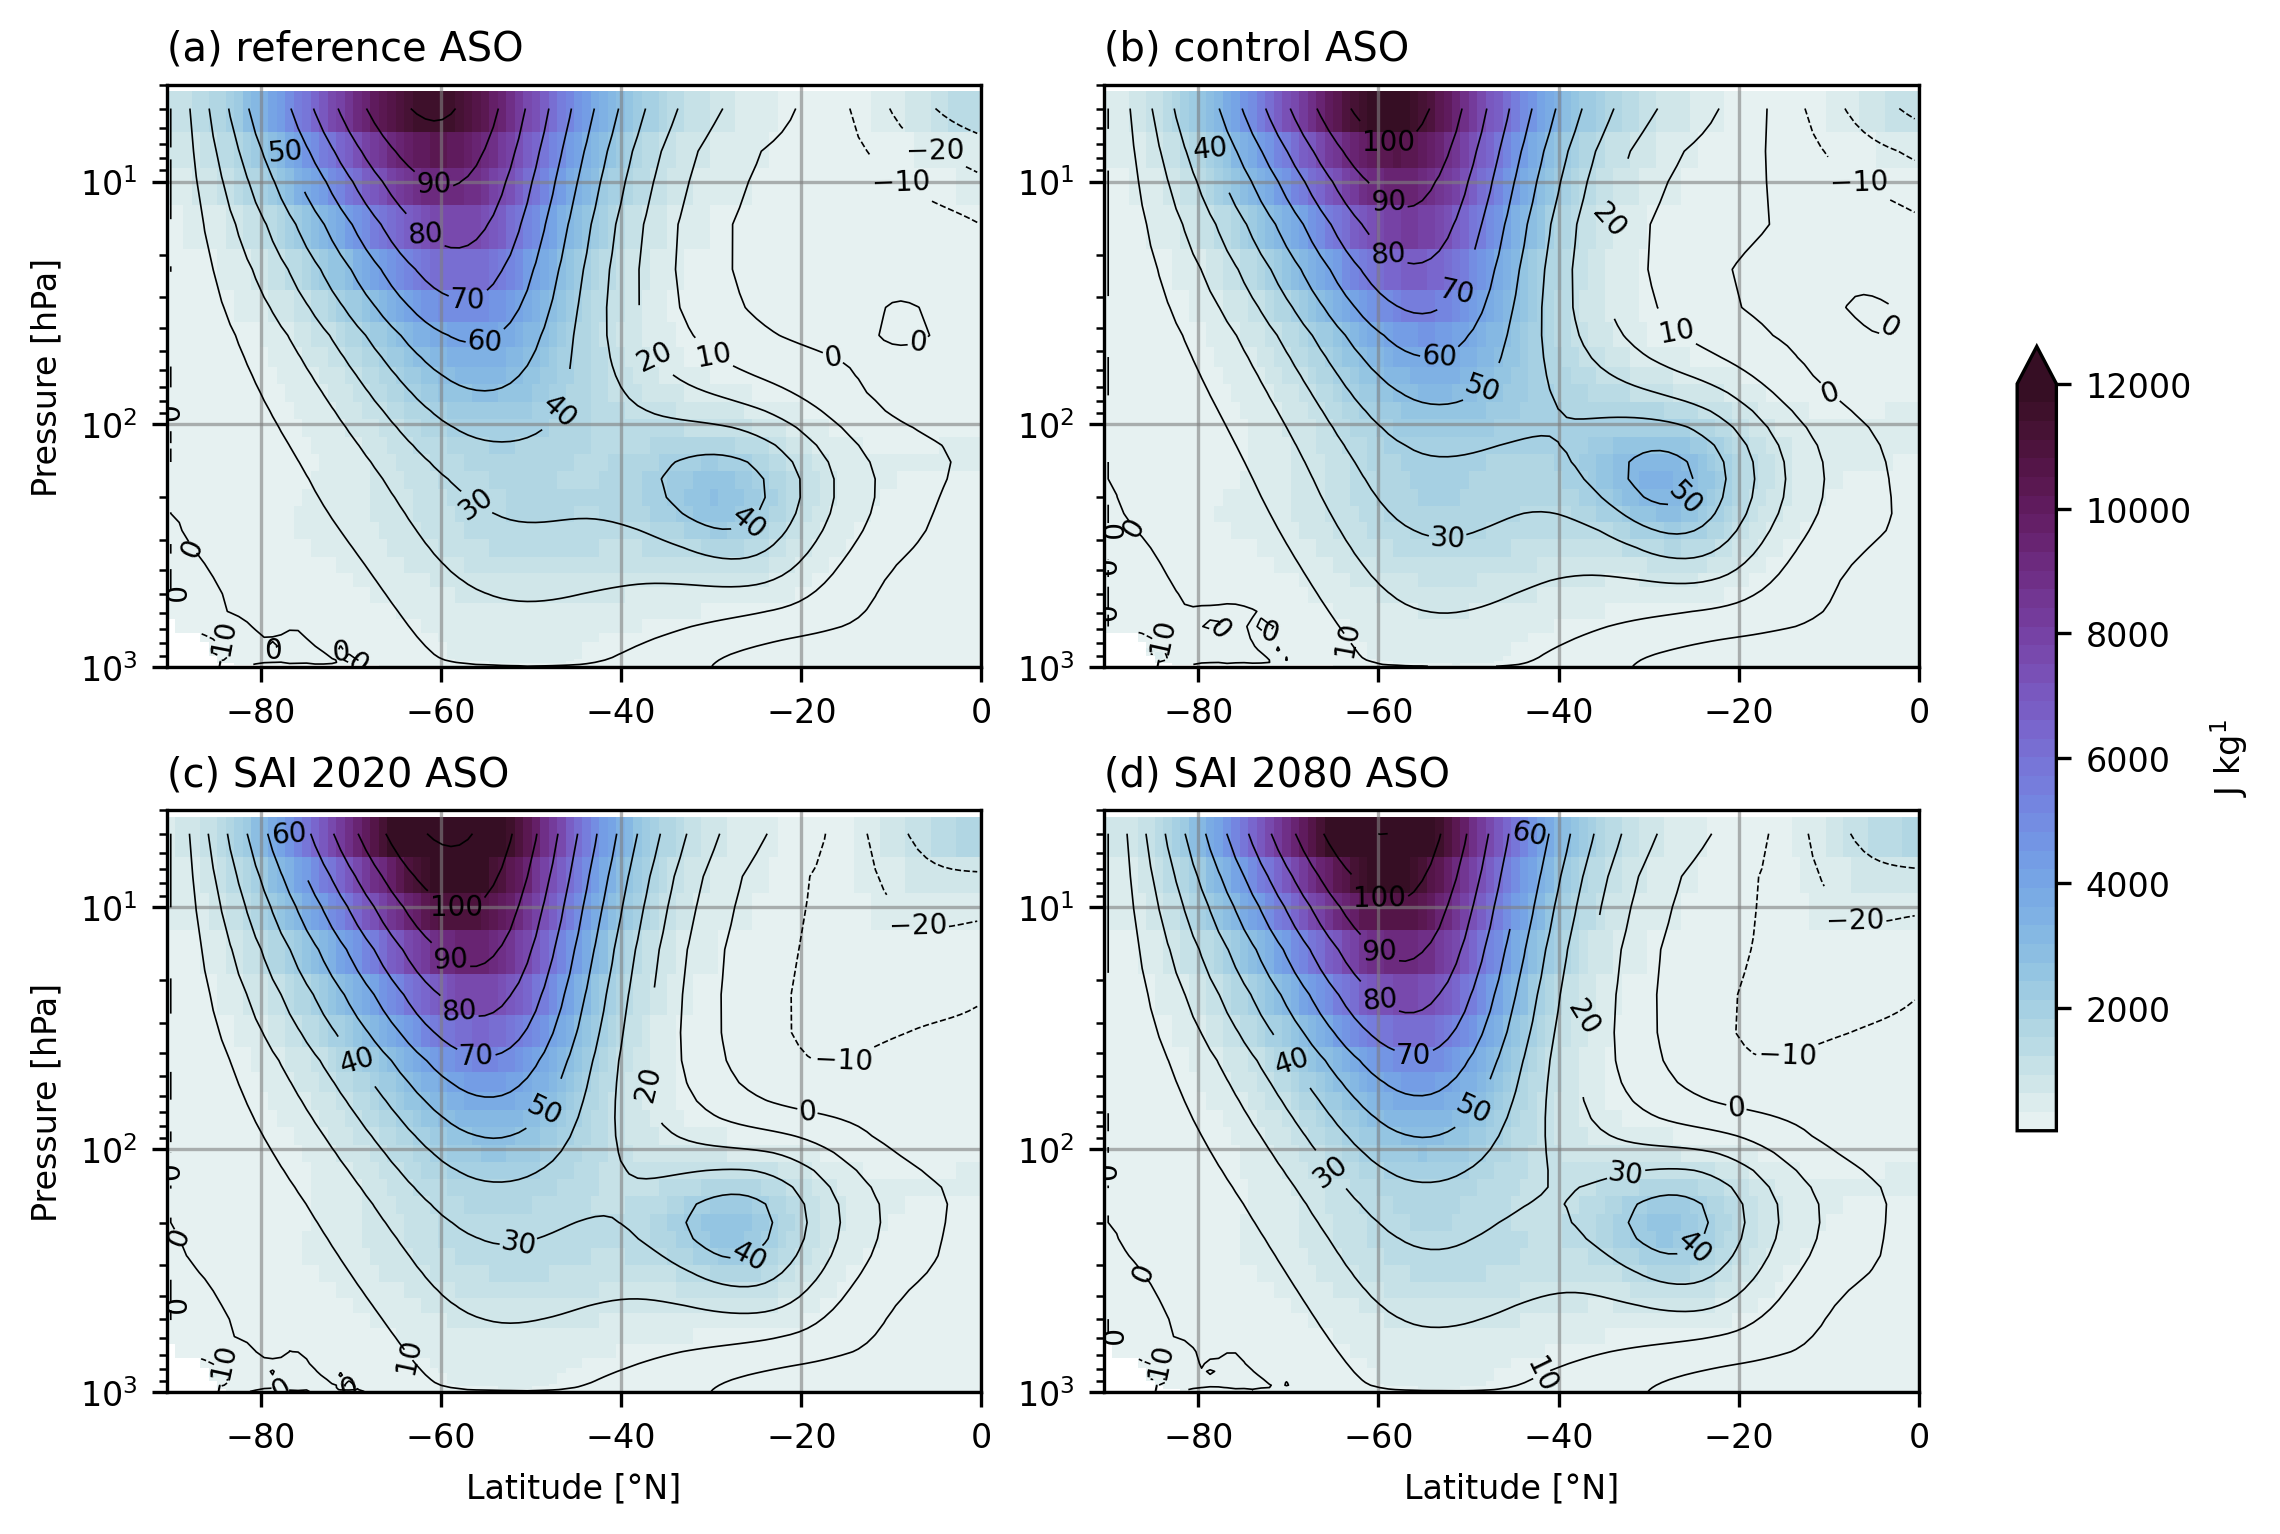

In [30]:
scen_used = ['i_c', 'f_c', 'f_20', 'f_80']
labels = ['(a) reference ASO', '(b) control ASO', '(c) SAI 2020 ASO', '(d) SAI 2080 ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained')

for i,j,k in zip(axs.flatten(),scen_used,labels):
    im = KEmzm[j].plot(ax=i, x='lat', y='plev', cmap=plt.get_cmap('cmo.dense',40), vmax=12000, add_colorbar=False)

    plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-120, vmax=120, levels=25, kwargs=dict(inline=True))
    i.clabel(plot, fontsize='small', inline_spacing=1)

    i.set_xlabel(None)
    i.set_ylabel(None)
    i.invert_yaxis()
    i.set_yscale('log')
    i.grid(color='gray', alpha=0.6)
    i.set_ylim(10**3,4)

    i.set_title(k, loc='left')

axs[1,0].set_xlabel('Latitude [°N]')
axs[1,1].set_xlabel('Latitude [°N]')
axs[0,0].set_ylabel('Pressure [hPa]')
axs[1,0].set_ylabel('Pressure [hPa]')


plt.colorbar(im, ax=axs, shrink=0.6, location='right', label=r'J kg$^1$', extend='max')

if save == True: plt.savefig(savepath+'PNJ_KE_U_zm.png');

In [31]:
for i,j in zip(diffscens,scen[1:]):
    # KEmzm[i] = ((KEmzm[j] - KEmzm['i_c'])/KEmzm['i_c']*100).compute()
    # EKEmzm[i] = ((EKEmzm[j] - EKEmzm['i_c'])/EKEmzm['i_c']*100).compute()

    KEmzm[i] = (KEmzm[j] - KEmzm['i_c']).compute()
    EKEmzm[i] = (EKEmzm[j] - EKEmzm['i_c']).compute()
    Uzm[i] = (Uzm[j] - Uzm['i_c']).compute()


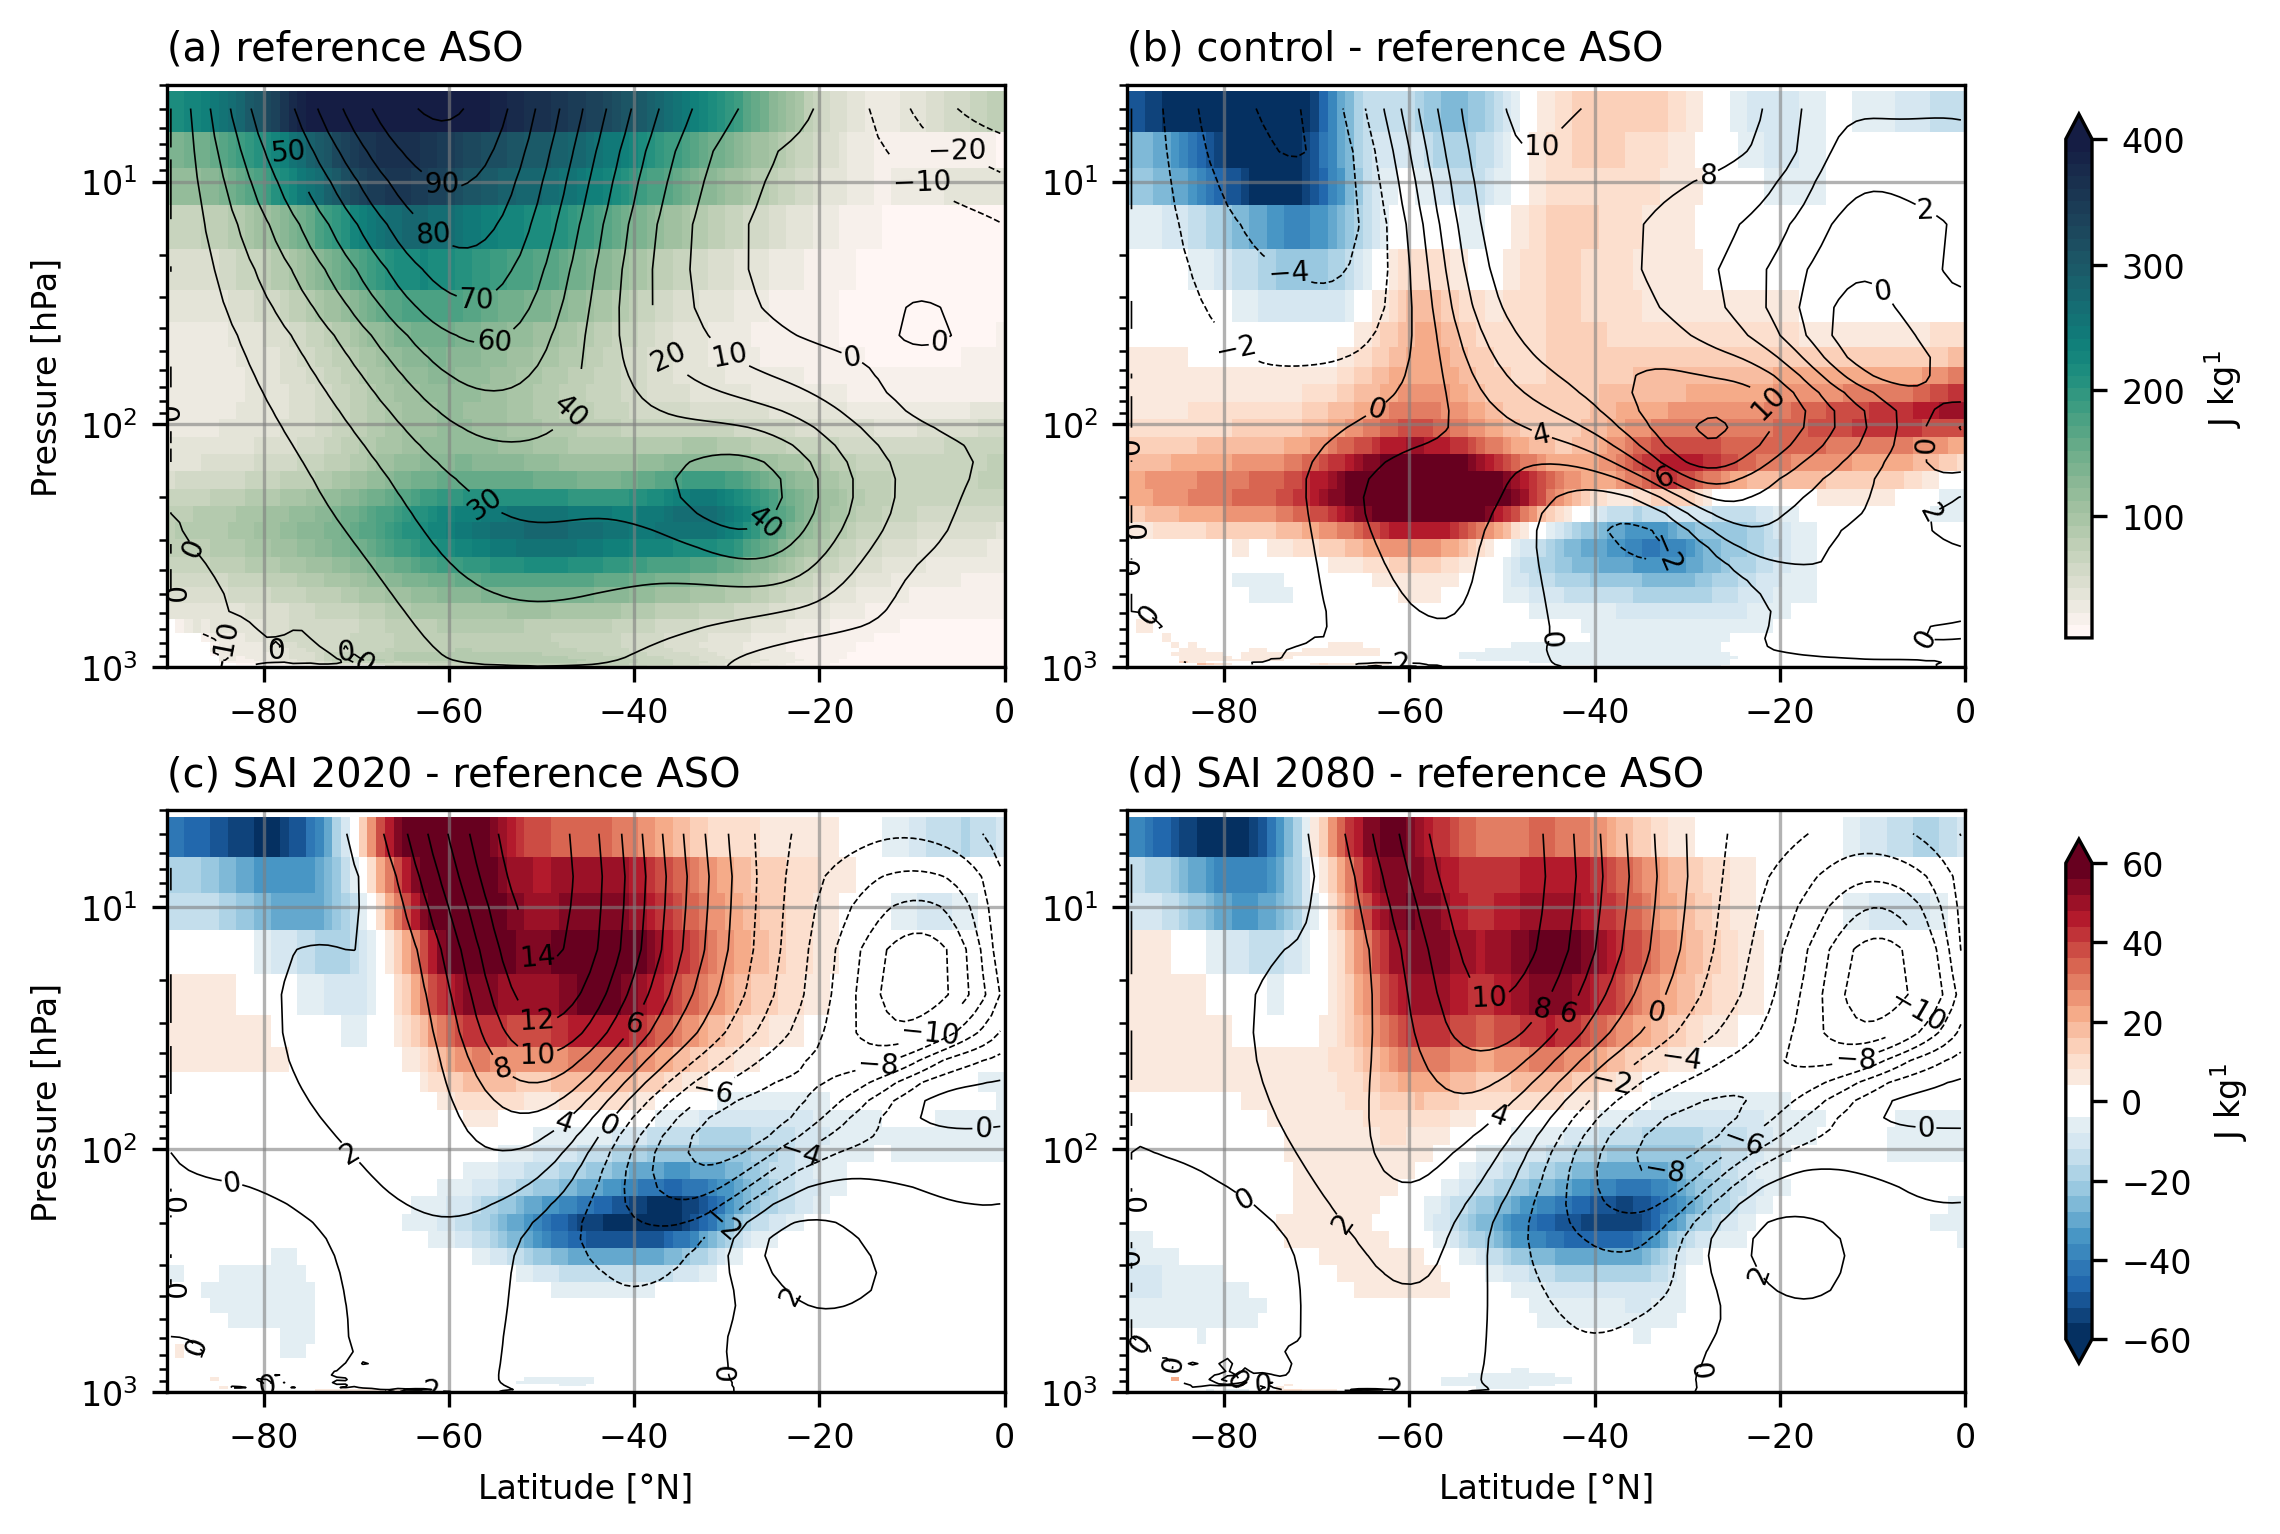

In [32]:
scen_used = ['i_c', 'cref', '20ref', '80ref']
labels = ['(a) reference ASO', '(b) control - reference ASO', '(c) SAI 2020 - reference ASO', '(d) SAI 2080 - reference ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained')

yoink = mpl.colormaps['RdBu_r'].resampled(30)
newcolors = yoink(np.linspace(0,1,30))
white = np.array([1, 1, 1, 1])
newcolors[14:16,:] = white
comap = colors.ListedColormap(newcolors)

for i,j,k in zip(axs.flatten(),scen_used,labels):
    if j == 'i_c':
        im = EKEmzm[j].plot(ax=i, x='lat', y='plev', cmap=plt.get_cmap('cmo.tempo',40), vmax=400, add_colorbar=False)
    
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-120, vmax=120, levels=25, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
    
        i.set_title(k, loc='left')
    else:
        im2 = EKEmzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, vmin=-60, vmax=60, add_colorbar=False)
    
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-16, vmax=16, levels=17, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
    
        i.set_title(k, loc='left')

axs[1,0].set_xlabel('Latitude [°N]')
axs[1,1].set_xlabel('Latitude [°N]')
axs[0,0].set_ylabel('Pressure [hPa]')
axs[1,0].set_ylabel('Pressure [hPa]')


plt.colorbar(im, ax=axs[0,:], shrink=0.9, location='right', label=r'J kg$^1$', extend='max')
plt.colorbar(im2, ax=axs[1,:], shrink=0.9, location='right', label=r'J kg$^1$', extend='both')

if save == True: plt.savefig(savepath+'PNJ_EKE_U_zmdiff.png');
    

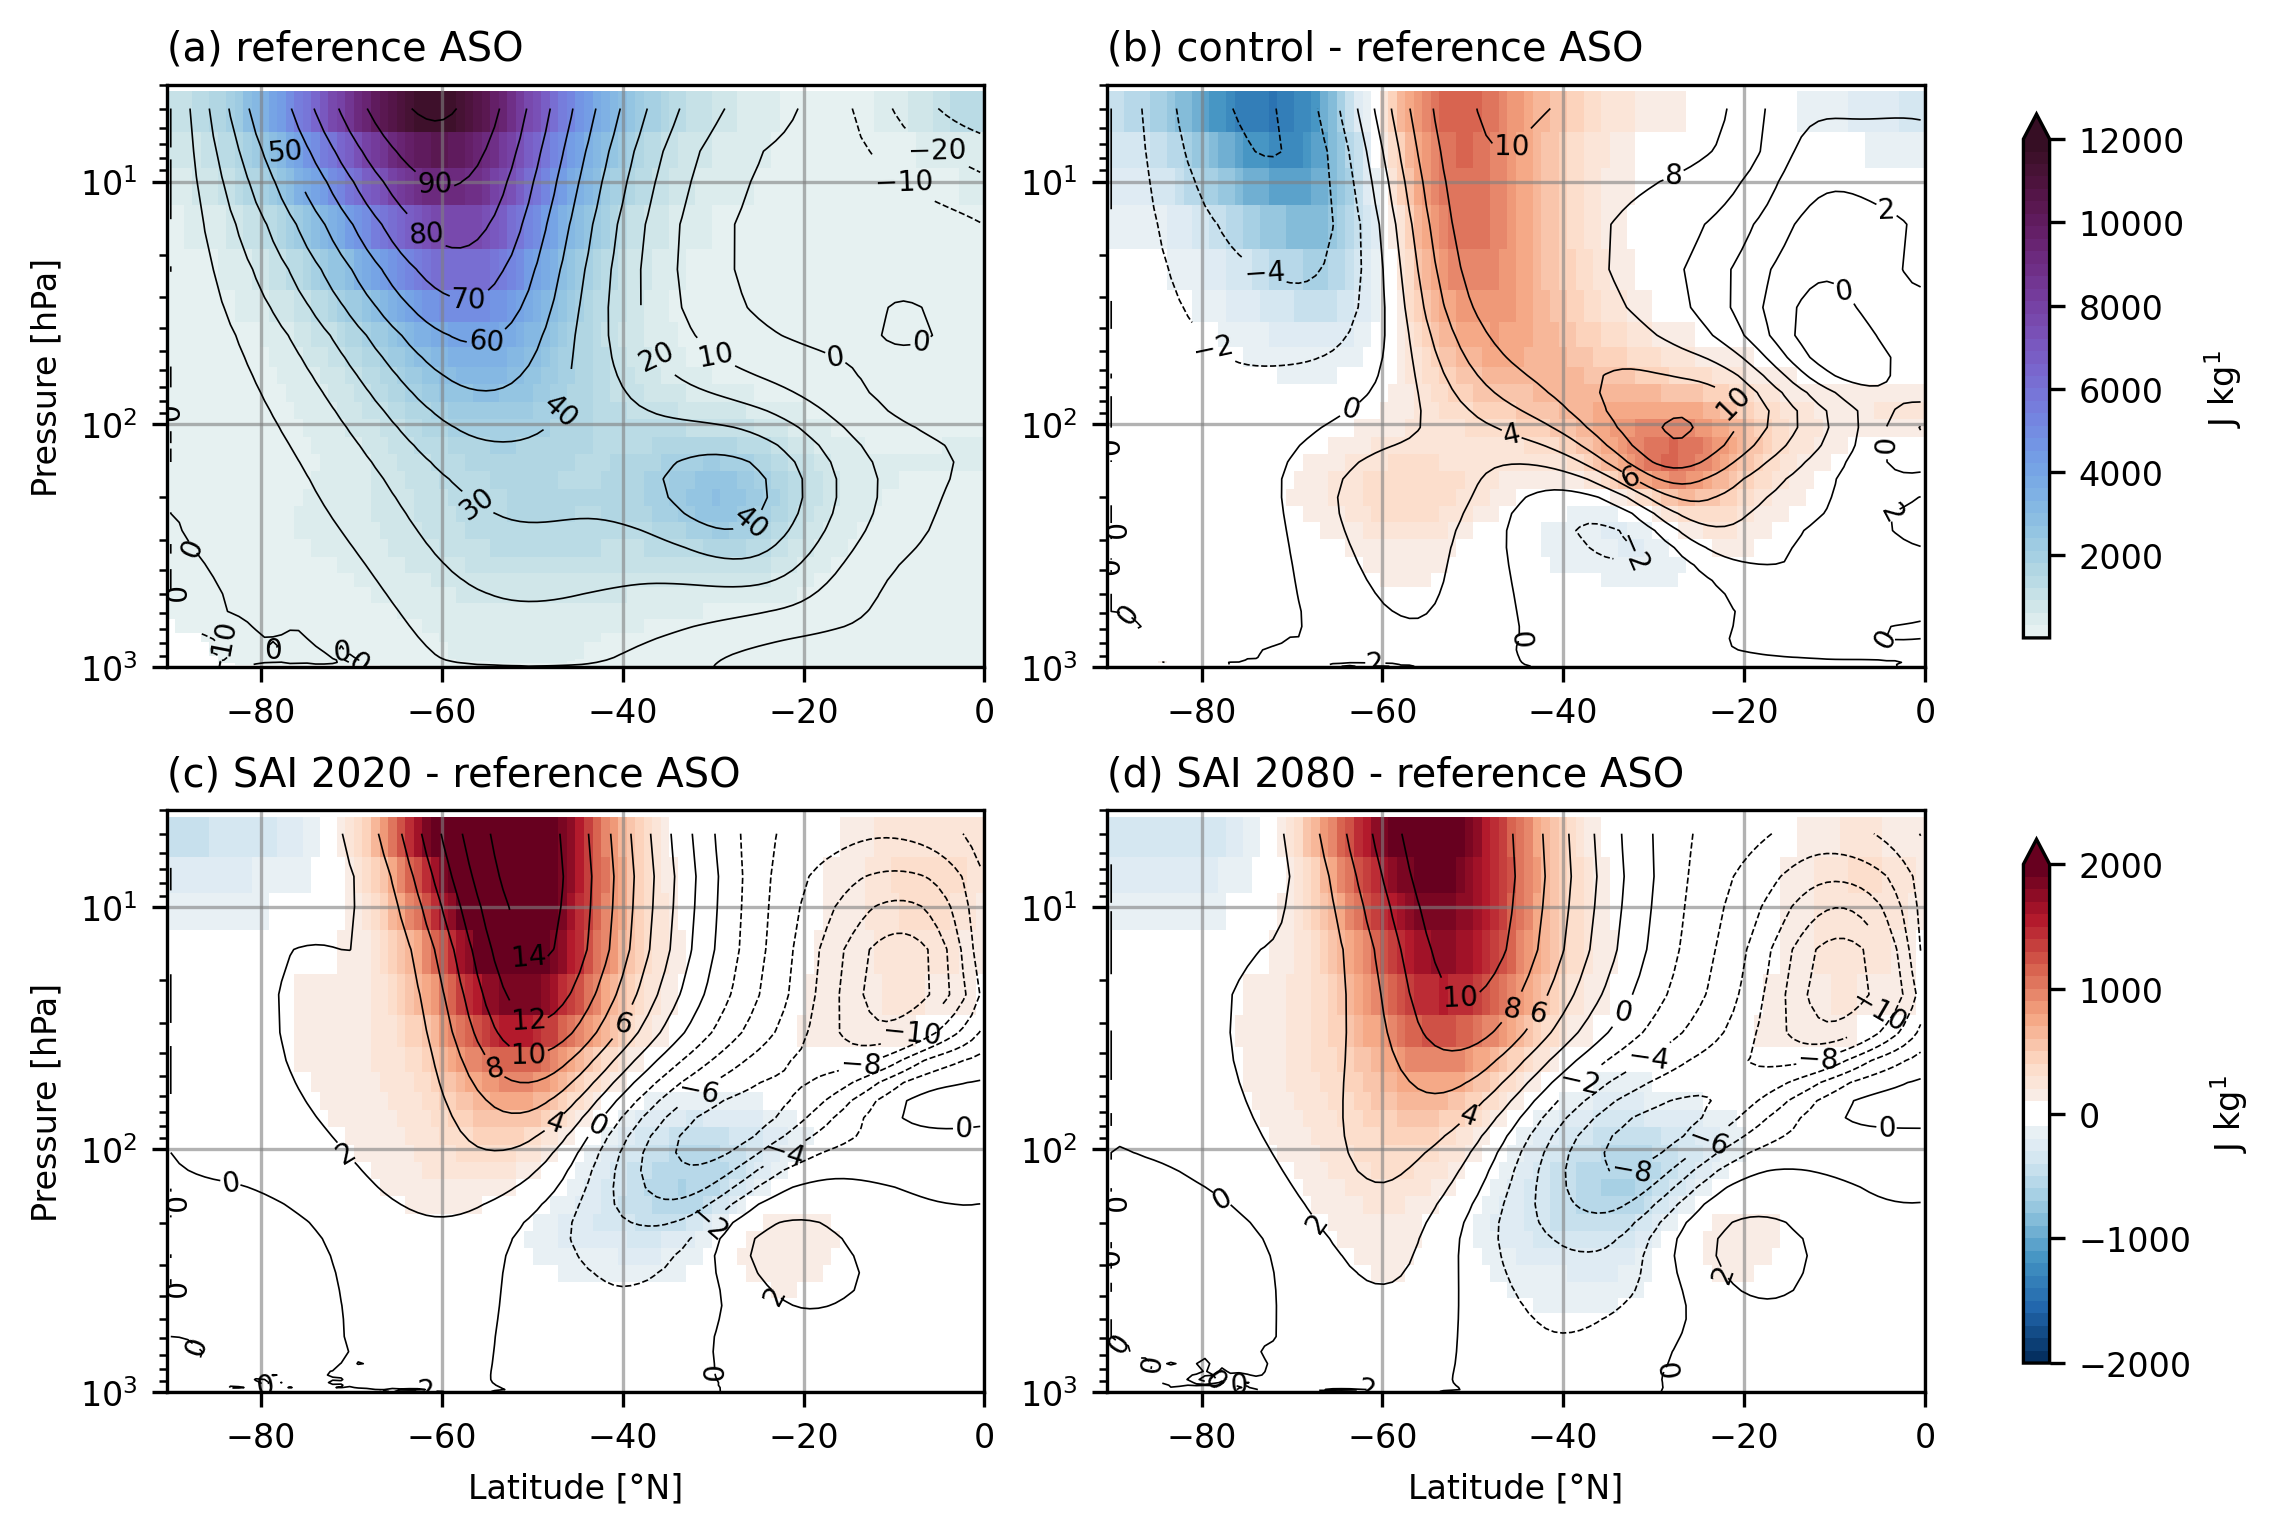

In [33]:
scen_used = ['i_c', 'cref', '20ref', '80ref']
labels = ['(a) reference ASO', '(b) control - reference ASO', '(c) SAI 2020 - reference ASO', '(d) SAI 2080 - reference ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained')

yoink = mpl.colormaps['RdBu_r'].resampled(40)
newcolors = yoink(np.linspace(0,1,40))
white = np.array([1, 1, 1, 1])
newcolors[19:21,:] = white
comap = colors.ListedColormap(newcolors)

for i,j,k in zip(axs.flatten(),scen_used,labels):
    if j == 'i_c':
        im = KEmzm[j].plot(ax=i, x='lat', y='plev', cmap=plt.get_cmap('cmo.dense',40), vmax=12000, add_colorbar=False)
    
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-120, vmax=120, levels=25, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
    
        i.set_title(k, loc='left')
    else:
        im2 = KEmzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, vmin=-2000, vmax=2000, add_colorbar=False)
    
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-16, vmax=16, levels=17, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
    
        i.set_title(k, loc='left')

axs[1,0].set_xlabel('Latitude [°N]')
axs[1,1].set_xlabel('Latitude [°N]')
axs[0,0].set_ylabel('Pressure [hPa]')
axs[1,0].set_ylabel('Pressure [hPa]')


plt.colorbar(im, ax=axs[0,:], shrink=0.9, location='right', label=r'J kg$^1$', extend='max')
plt.colorbar(im2, ax=axs[1,:], shrink=0.9, location='right', label=r'J kg$^1$', extend='max')

if save == True: plt.savefig(savepath+'PNJ_KE_U_zmdiff.png');
    

# Thermal wind

In [34]:
UTzm = {}
for i in scen:
    UTzm[i] = time_mean(Twind(T[i].sel(time=T[i].time.dt.month.isin([8,9,10])), U[i].sel(time=U[i].time.dt.month.isin([8,9,10]))))['uT'].mean(dim='lon')




In [35]:
for i in scen:
    UTzm[i].compute()

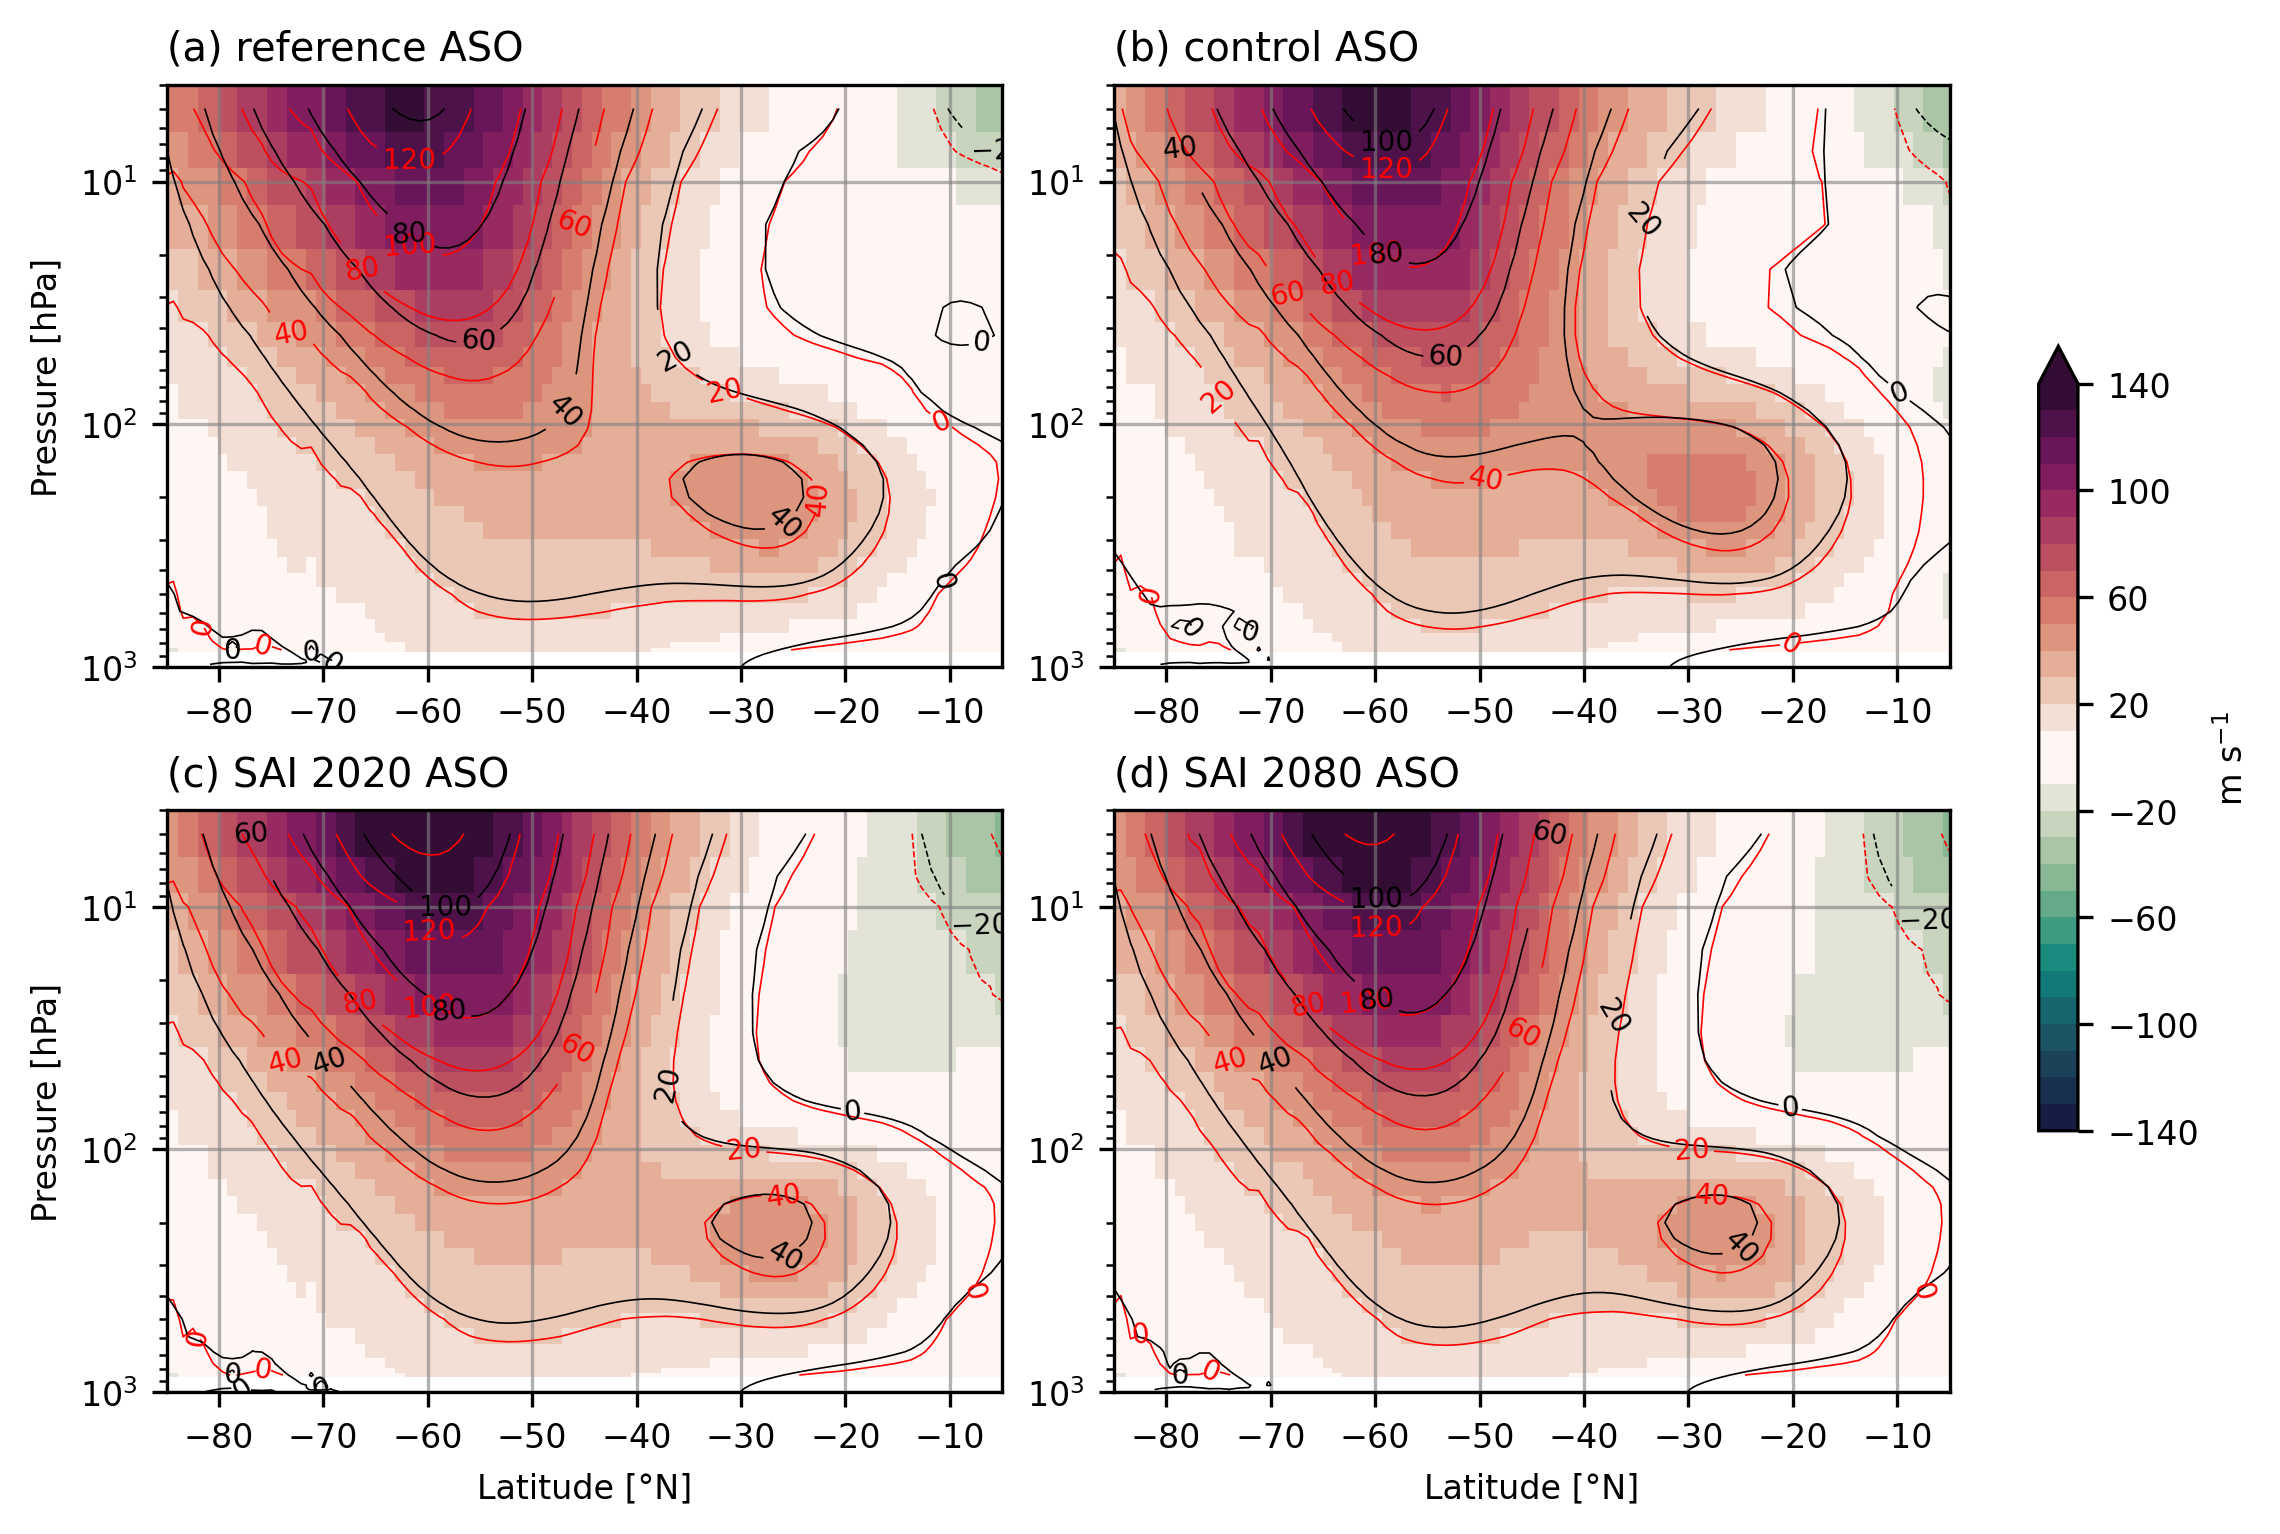

In [36]:
scen_used = ['i_c', 'f_c', 'f_20', 'f_80']
labels = ['(a) reference ASO', '(b) control ASO', '(c) SAI 2020 ASO', '(d) SAI 2080 ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained')

comap = plt.get_cmap('cmo.curl')
bounds = np.concatenate([np.arange(-140,-1,10), np.arange(10,141,10)])
norm = colors.BoundaryNorm(bounds, comap.N)

for i,j,k in zip(axs.flatten(),scen_used,labels):
    im = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, norm=norm, add_colorbar=False)

    plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
    i.clabel(plot, fontsize='small', inline_spacing=1)

    plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
    i.clabel(plot, fontsize='small', inline_spacing=1)

    i.set_xlabel(None)
    i.set_ylabel(None)
    i.invert_yaxis()
    i.set_yscale('log')
    i.grid(color='gray', alpha=0.6)
    i.set_ylim(10**3,4)
    i.set_xlim(-85,-5)

    i.set_title(k, loc='left')

axs[1,0].set_xlabel('Latitude [°N]')
axs[1,1].set_xlabel('Latitude [°N]')
axs[0,0].set_ylabel('Pressure [hPa]')
axs[1,0].set_ylabel('Pressure [hPa]')


plt.colorbar(im, ax=axs, shrink=0.6, location='right', label=r'm s$^{-1}$', extend='max', ticks=[-140,-100,-60,-20,20,60,100,140], spacing='proportional').minorticks_off()

if save == True: plt.savefig(savepath+'PNJ_UT_U_zm.png');


In [37]:
for i,j in zip(diffscens,scen[1:]):
    UTzm[i] = (UTzm[j] - UTzm['i_c']).compute()


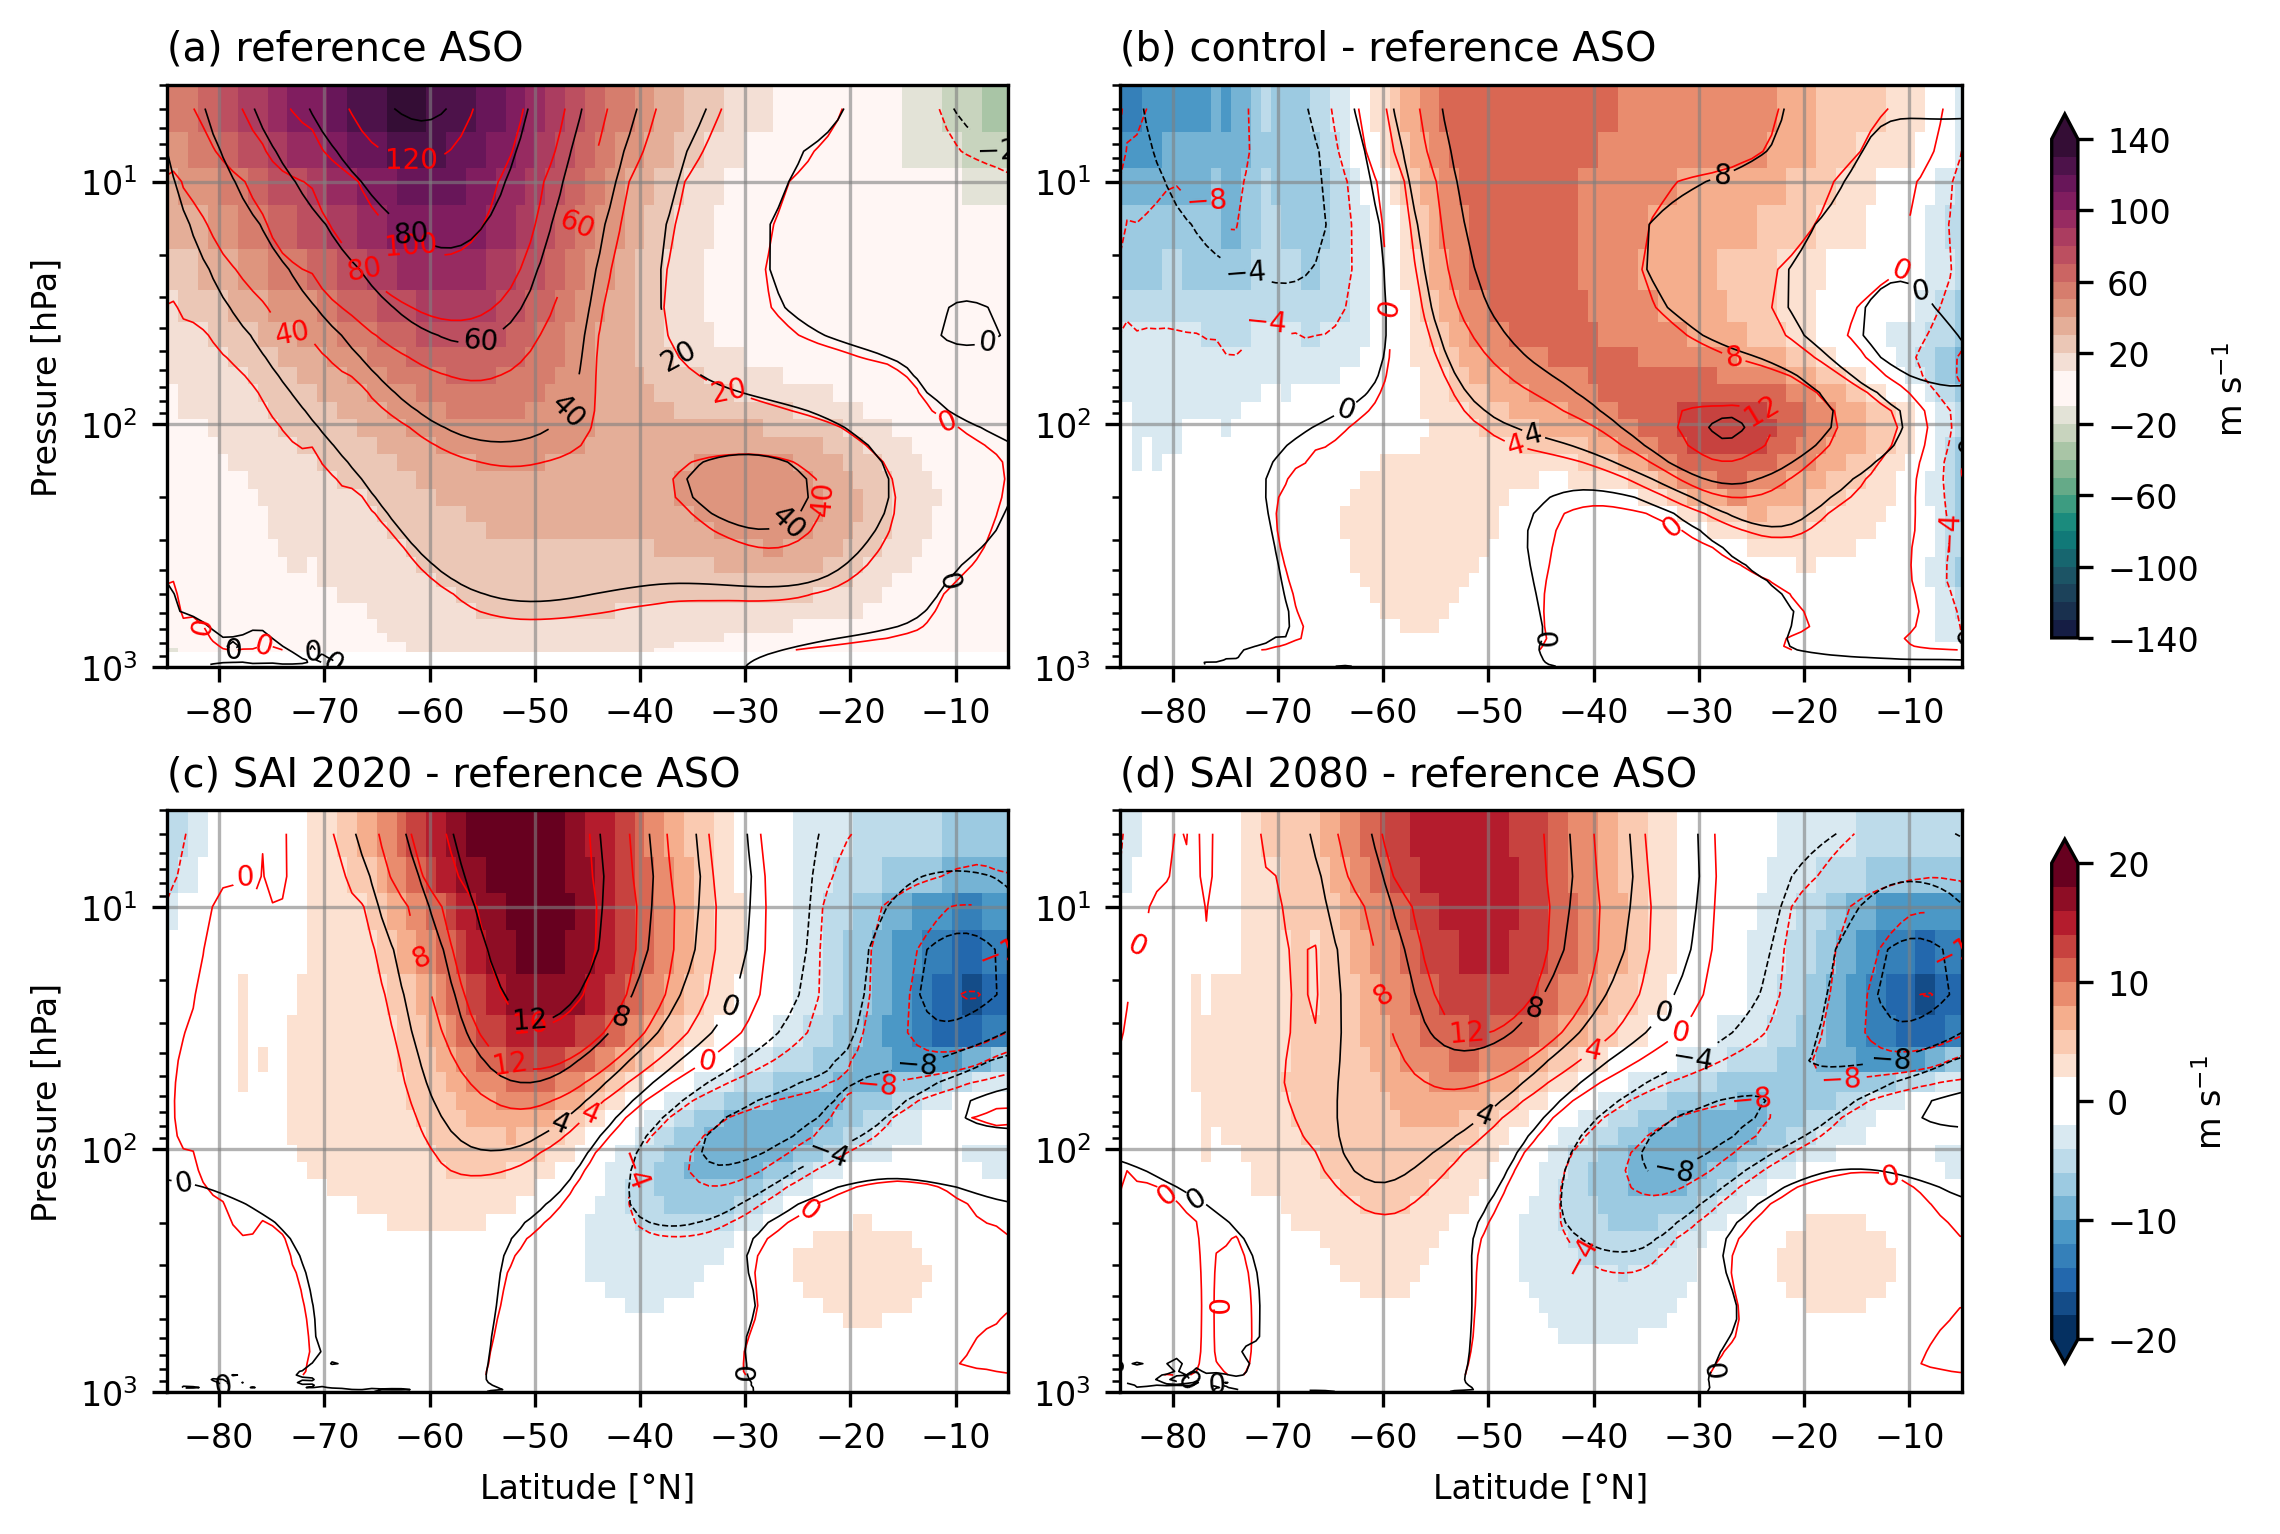

In [38]:
scen_used = ['i_c', 'cref', '20ref', '80ref']
labels = ['(a) reference ASO', '(b) control - reference ASO', '(c) SAI 2020 - reference ASO', '(d) SAI 2080 - reference ASO']

fig, axs = plt.subplots(2, 2, figsize=imgsize3, layout='constrained')

comapn = plt.get_cmap('cmo.curl')
bounds = np.concatenate([np.arange(-140,-1,10), np.arange(10,141,10)])
norm = colors.BoundaryNorm(bounds, comapn.N)

yoink = mpl.colormaps['RdBu_r'].resampled(20)
newcolors = yoink(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
comap = colors.ListedColormap(newcolors)

for i,j,k in zip(axs.flatten(),scen_used,labels):
    if j == 'i_c':
        ima = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=comapn, norm=norm, add_colorbar=False)
        
        plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
        
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
        i.set_xlim(-85,-5)
    
        i.set_title(k, loc='left')
    else:
        imb = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, vmin=-20, vmax=20, add_colorbar=False)
    
        plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-20, vmax=20, levels=11, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)

        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-16, vmax=16, levels=9, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
        i.set_xlim(-85,-5)

        i.set_title(k, loc='left')

axs[1,0].set_xlabel('Latitude [°N]')
axs[1,1].set_xlabel('Latitude [°N]')
axs[0,0].set_ylabel('Pressure [hPa]')
axs[1,0].set_ylabel('Pressure [hPa]')


plt.colorbar(ima, ax=axs[0,:], shrink=0.9, location='right', label=r'm s$^{-1}$', extend='max', ticks=[-140,-100,-60,-20,20,60,100,140], spacing='proportional').minorticks_off()
plt.colorbar(imb, ax=axs[1,:], shrink=0.9, location='right', label=r'm s$^{-1}$', extend='both')

if save == True: plt.savefig(savepath+'PNJ_UT_U_zmdiff.png');
    